<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/Bonus_Autoencoders/Bonus_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/Bonus_Autoencoders/Bonus_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Autoencoders applications
**Bonus Day: Autoencoders**

**By Neuromatch Academy**

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team (2014-2018)

__Content reviewers:__ Itzel Olivos, Karen Schroeder, Karolina Stosio, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

## Autoencoder applications

How do autoencoders with rich internal representations perform on the MNIST cognitive task?

How do autoencoders perceive unseen digit classes? 

How does ANN image encoding differ from human vision?

We are equipped with tools and techniques to answer these questions, and hopefully, many others you may encounter in your research!

<br>

![MNIST cognitive task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mnist_task.png)

<br>

In this tutorial, you will:
- Analyze how autoencoders perceive transformed data (added noise, occluded parts, and rotations), and how that evolves with short re-train sessions
- Use autoencoders to visualize unseen digit classes
- Understand visual encoding for fully connected ANN autoencoders

In [3]:
# @title Video 1: Applications
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV12v411q7nS", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="_bzW_jkH6l0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Setup
Please execute the cell(s) below to initialize the notebook environment.

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage

import torch
from torch import nn, optim

from sklearn.datasets import fetch_openml

In [5]:
# @title Figure settings

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [6]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy())

  return weights


def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.MSELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.BCELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

    plt.tight_layout()


def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates

  Returns:
    Sperical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:, 0], u[:, 1], u[:, 2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).

  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2

  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:, 0], s[:, 1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """
  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0] * n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)

      if s2:
        latent = to_u3(latent)

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j * image_shape[0]: (j + 1) * image_shape[0],
             i * image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)

  if s2:
    if xy_labels is None:
      xy_labels = [r'$\varphi$', r'$\theta$']

    plt.xticks(np.arange(0, np.pi + np.pi / 6, np.pi / 6),
               ['0', '$\pi/6$', '$\pi/3$', '$\pi/2$',
                '$2\pi/3$', '$5\pi/6$', '$\pi$'])
    plt.yticks(np.arange(-np.pi, np.pi + np.pi / 3, np.pi / 3),
               ['$-\pi$', '$-2\pi/3$', '$-\pi/3$', '0',
                '$\pi/3$', '$2\pi/3$', '$\pi$'])

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False,
                           title=None, xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, s2=s2, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500, s2=False):
  """
  Two horizontal subplots with encoder maps.

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1) > show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  data = np.concatenate([x1, x2])

  if s2:
    xlim, ylim = xy_lim(to_s2(data))

  else:
    xlim, ylim = xy_lim(data)

  plt.figure(figsize=(12, 6))

  ax = plt.subplot(121)
  ax.set_title(title_a, y=1.05)
  plot_latent(x1, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)

  ax = plt.subplot(122)
  ax.set_title(title_b, y=1.05)
  plot_latent(x2, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.tight_layout()


def runSGD(net, input_train, input_test, out_train=None, out_test=None,
           optimizer=None, criterion='bce', n_epochs=10, batch_size=32,
           verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN network (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    out_train (torch.Tensor)
        optional target images from train set

    out_test (torch.Tensor)
        optional target images from test set

    optimizer (torch optimizer)
        optional target images from train set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  if out_train is not None and out_test is not None:
    different_output = True
  else:
    different_output = False

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  if optimizer is None:
    optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    if different_output:
      batches_out = torch.split(out_train[shuffle_idx], batch_size)

    for batch_idx, batch in enumerate(batches):

      output_train = net(batch)

      if different_output:
        loss = loss_fn(output_train, batches_out[batch_idx])
      else:
        loss = loss_fn(output_train, batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      if different_output:
        loss_train = loss_fn(output_train, out_train)
      else:
        loss_train = loss_fn(output_train, input_train)

      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      if different_output:
        loss_test = loss_fn(output_test, out_test)
      else:
        loss_test = loss_fn(output_test, input_test)

      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    if different_output:
      loss_mse = f'\nMSE\t {eval_mse(output_train, out_train):0.4f}'
      loss_mse += f'\t\t {eval_mse(output_test, out_test):0.4f}'
    else:
      loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
      loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    if different_output:
      loss_bce = f'BCE\t {eval_bce(output_train, out_train):0.4f}'
      loss_bce += f'\t\t {eval_bce(output_test, out_test):0.4f}'
    else:
      loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
      loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss)/500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()


def image_occlusion(x, image_shape):
  """
  Randomly selects on quadrant of images and sets to zeros.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    image_shape (tuple or list)
        original shape of image

  Returns:
    torch.Tensor.
  """

  selection = np.random.choice(4, len(x))

  my_x = np.array(x).copy()
  my_x = my_x.reshape(-1, image_shape[0], image_shape[1])

  my_x[selection == 0, :int(image_shape[0] / 2), :int(image_shape[1] / 2)] = 0
  my_x[selection == 1, int(image_shape[0] / 2):, :int(image_shape[1] / 2)] = 0
  my_x[selection == 2, :int(image_shape[0] / 2), int(image_shape[1] / 2):] = 0
  my_x[selection == 3, int(image_shape[0] / 2):, int(image_shape[1] / 2):] = 0

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


def image_rotation(x, deg, image_shape):
  """
  Randomly rotates images by +- deg degrees.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    deg (integer)
        rotation range

    image_shape (tuple or list)
        original shape of image

  Returns:
    torch.Tensor.
  """

  my_x = np.array(x).copy()
  my_x = my_x.reshape(-1, image_shape[0], image_shape[1])

  for idx, item in enumerate(my_x):
    my_deg = deg * 2 * np.random.random() - deg
    my_x[idx] = ndimage.rotate(my_x[idx], my_deg,
                               reshape=False, prefilter=False)

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


class AutoencoderClass(nn.Module):
  """
  Deep autoencoder network object (nn.Module) with optional L2 normalization
  of activations in bottleneck layer.

  Args:
    input_size (integer)
        size of input samples

    s2 (boolean)
        whether to L2 normalize activatinos in bottleneck layer

  Returns:
    Autoencoder object inherited from nn.Module class.
  """

  def __init__(self, input_size=784, s2=False):

    super().__init__()

    self.input_size = input_size
    self.s2 = s2

    if s2:
      self.encoding_size = 3

    else:
      self.encoding_size = 2

    self.enc1 = nn.Linear(self.input_size, int(self.input_size / 2))
    self.enc1_f = nn.PReLU()
    self.enc2 = nn.Linear(int(self.input_size / 2), self.encoding_size * 32)
    self.enc2_f = nn.PReLU()
    self.enc3 = nn.Linear(self.encoding_size * 32, self.encoding_size)
    self.enc3_f = nn.PReLU()
    self.dec1 = nn.Linear(self.encoding_size, self.encoding_size * 32)
    self.dec1_f = nn.PReLU()
    self.dec2 = nn.Linear(self.encoding_size * 32, int(self.input_size / 2))
    self.dec2_f = nn.PReLU()
    self.dec3 = nn.Linear(int(self.input_size / 2), self.input_size)
    self.dec3_f = nn.Sigmoid()

  def encoder(self, x):
    """
    Encoder component.
    """
    x = self.enc1_f(self.enc1(x))
    x = self.enc2_f(self.enc2(x))
    x = self.enc3_f(self.enc3(x))

    if self.s2:
        x = nn.functional.normalize(x, p=2, dim=1)

    return x

  def decoder(self, x):
    """
    Decoder component.
    """
    x = self.dec1_f(self.dec1(x))
    x = self.dec2_f(self.dec2(x))
    x = self.dec3_f(self.dec3(x))

    return x

  def forward(self, x):
    """
    Forward pass.
    """
    x = self.encoder(x)
    x = self.decoder(x)

    return x


def save_checkpoint(net, optimizer, filename):
  """
  Saves a PyTorch checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    filename (string)
        filename (without extension)

  Returns:
    Nothing.
  """

  torch.save({'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()},
             filename+'.pt')


def load_checkpoint(url, filename):
  """
  Loads a PyTorch checkpoint from URL is local file not present.

  Args:
    url (string)
        URL location of PyTorch checkpoint

    filename (string)
        filename (without extension)

  Returns:
    PyTorch checkpoint of saved model.
  """

  if not os.path.isfile(filename+'.pt'):
    os.system(f"wget {url}.pt")

  return torch.load(filename+'.pt')


def reset_checkpoint(net, optimizer, checkpoint):
  """
  Resets PyTorch model to checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    checkpoint (torch checkpoint)
        checkpoint of saved model

  Returns:
    Nothing.
  """

  net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

---
# Section 1: Download  and prepare MNIST dataset
We use the helper function `downloadMNIST` to download the dataset and transform it into `torch.Tensor` and assign train and test sets to (`x_train`, `y_train`) and (`x_test`, `y_test`).

The variable `input_size` stores the length of *vectorized* versions of the images `input_train` and `input_test` for training and test images.

**Instructions:**
* Please execute the cell below

In [7]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

test_subset_idx = np.random.choice(len(x_test), 500, replace=False)

print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


---
# Section 2: Download a pre-trained model
The class `AutoencoderClass` implements the autoencoder architectures introduced in the previous tutorial. The design of this class follows the object-oriented programming (OOP) style from tutorial W3D4. Setting the boolean parameter `s2=True` specifies the model with projection onto the $S_2$ sphere.

We trained both models for `n_epochs=25` and saved the weights to avoid a lengthy initial training period - these will be our reference model states.

Experiments are run from the identical initial conditions by resetting the autoencoder to the reference state at the beginning of each exercise. 

The mechanism for loading and storing models from PyTorch is the following:
```
model = nn.Sequential(...)
or
model = AutoencoderClass()

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
           filename_path)

checkpoint = torch.load(filename_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```
See additional [PyTorch instructions](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html), and when to use `model.eval()` and `model.train()` for more complex models.

We provide the functions `save_checkpoint`, `load_checkpoint`, and `reset_checkpoint` to implement the steps above and download pre-trained weights from the GitHub repo.

If downloading from GitHub fails, please uncomment the 3rd cell bellow to train the model for `n_epochs=10` and save it locally.

**Instructions:**
* Please execute the cell(s) below

In [8]:
root = 'https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders'
filename = 'ae_6h_prelu_bce_adam_25e_32b'
url = os.path.join(root, filename)
s2 = True

if s2:
  filename += '_s2'
  url += '_s2'

In [9]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

checkpoint = load_checkpoint(url, filename)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

--2022-08-26 10:18:53--  https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mpbrigham/colaboratory-figures/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt [following]
--2022-08-26 10:18:54--  https://raw.githubusercontent.com/mpbrigham/colaboratory-figures/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8313616 (7.9M) [application/octet-stream]
Saving to: ‘ae_6h_prelu_bce_adam_25e_32b_s2.pt’

     0K .......... ...

In [10]:
# Please uncomment and execute this cell if download of
# pre-trained weights fail

# model = AutoencoderClass(s2=s2)
# encoder = model.encoder
# decoder = model.decoder
# n_epochs = 10
# batch_size = 128
# runSGD(model, input_train, input_test,
#        n_epochs=n_epochs, batch_size=batch_size)
# save_checkpoint(model, optimizer, filename)
# checkpoint = load_checkpoint(url, filename)

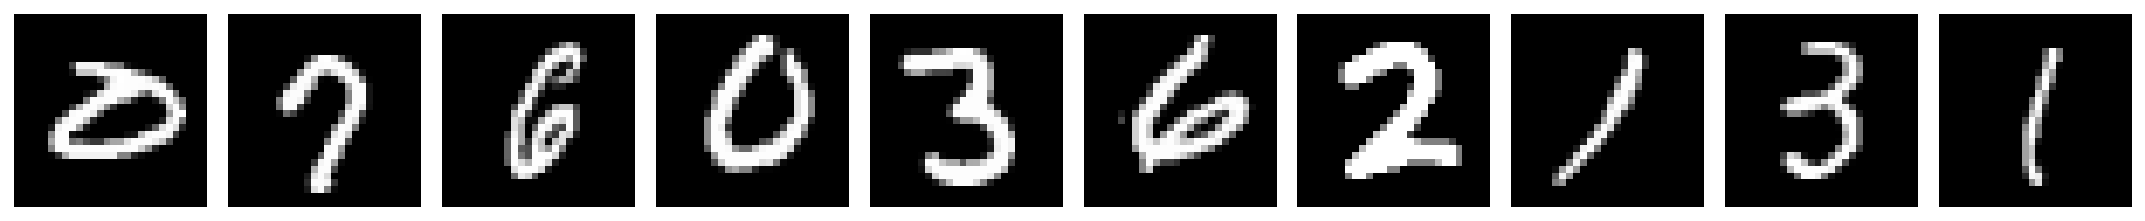

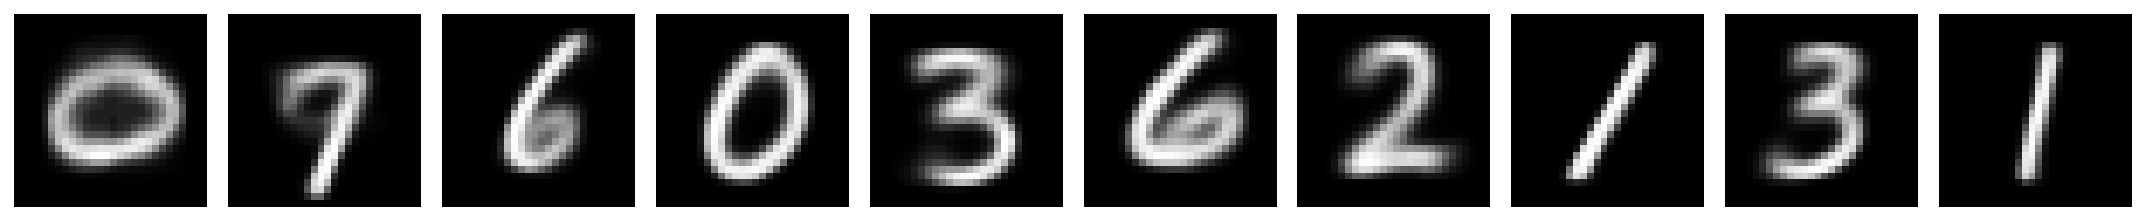

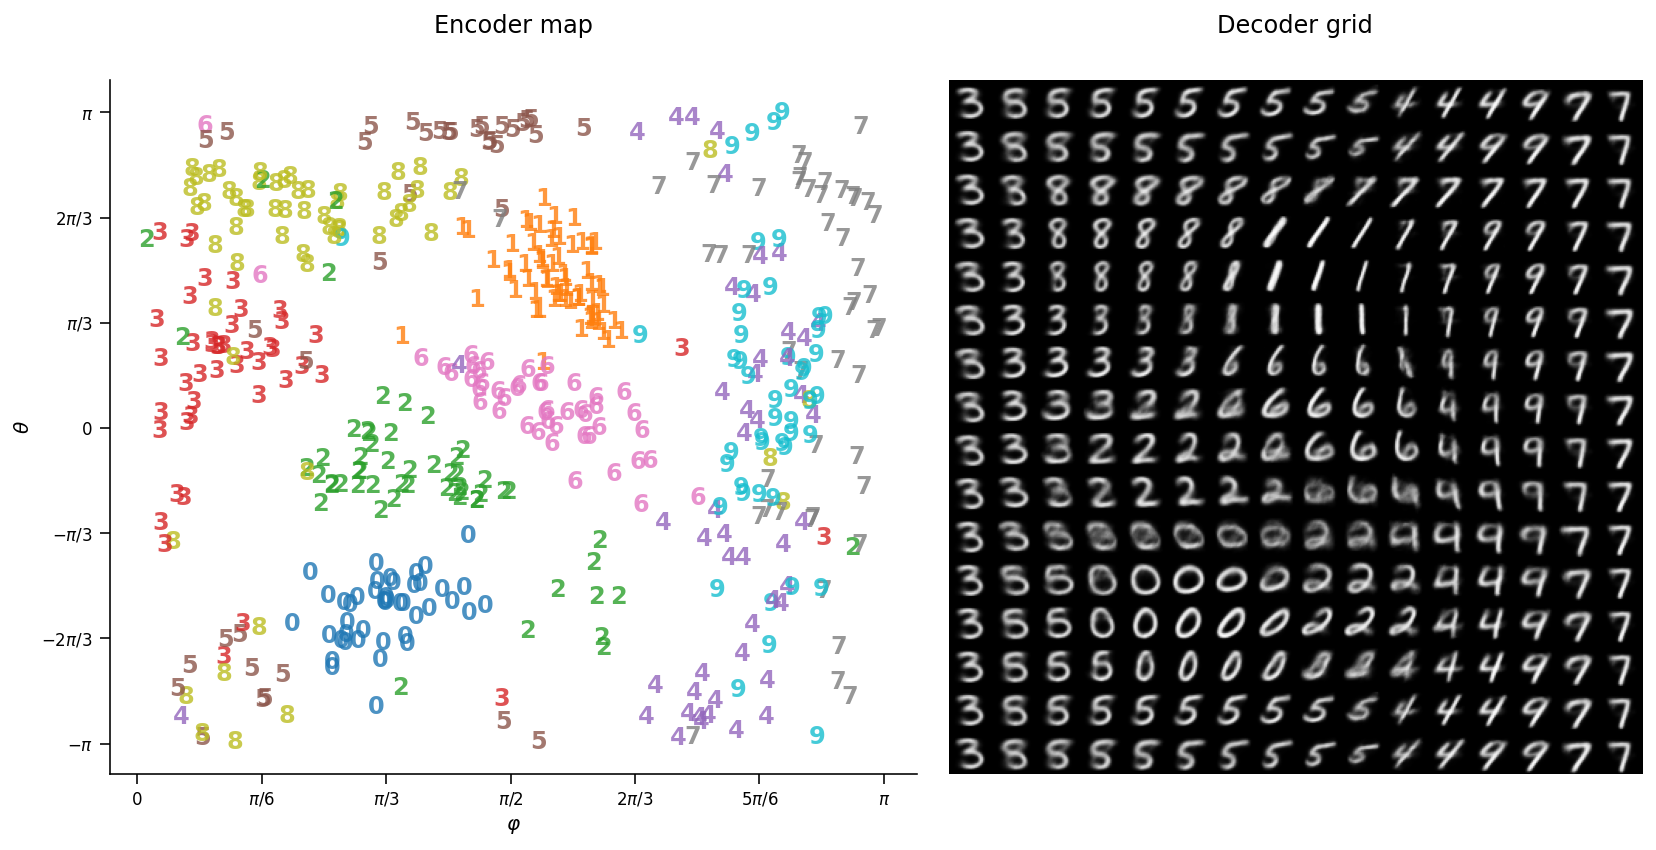

In [11]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape, s2=s2)

---
# Section 3: Applications of autoencoders

## Application 1 - Image noise
Removing noise added to images is often showcased in dimensionality reduction techniques. The tutorial  *W1D5 Dimensionality reduction* illustrated this capability with PCA.

We first observe that autoencoders trained with noise-free images output noise-free images when receiving noisy images as input.  However, the reconstructed images will be different from the original images (without noise) since the added noise maps to different coordinates in latent space.

The ability to map noise-free and noisy versions to similar regions in latent space is known as *robustness* or *invariance* to noise. How can we build such functionality into the autoencoder? 

The solution is to train the autoencoder with noise-free and noisy versions mapping to the noise-free version. A faster alternative is to re-train the autoencoder for few epochs with noisy images. These short training sessions fine-tune the weights to map noisy images to their noise-free versions from similar latent space coordinates.

Let's start by resetting to the reference state of the autoencoder.

**Instructions:**
* Please execute the cells below

In [12]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Reconstructions before fine-tuning

Let's verify that an autoencoder trained on clean images will output clean images from noisy inputs. We visualize this by plotting three rows:
* Top row with noisy images inputs
* Middle row with reconstructions of noisy images
* Bottom row with reconstructions of the original images (noise-free)

![Noise task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/applications_noise.png)

The bottom row helps identify samples with reconstruction issues before adding noise. This row shows the baseline reconstruction quality for these samples rather than the original images. (Why?)

**Instructions:**
* Please execute the cell(s) below

In [13]:
noise_factor = 0.4

input_train_noisy = (input_train
                     + noise_factor * np.random.normal(size=input_train.shape))
input_train_noisy = np.clip(input_train_noisy, input_train.min(),
                            input_train.max(), dtype=np.float32)

input_test_noisy = (input_test
                    + noise_factor * np.random.normal(size=input_test.shape))
input_test_noisy = np.clip(input_test_noisy, input_test.min(),
                           input_test.max(), dtype=np.float32)

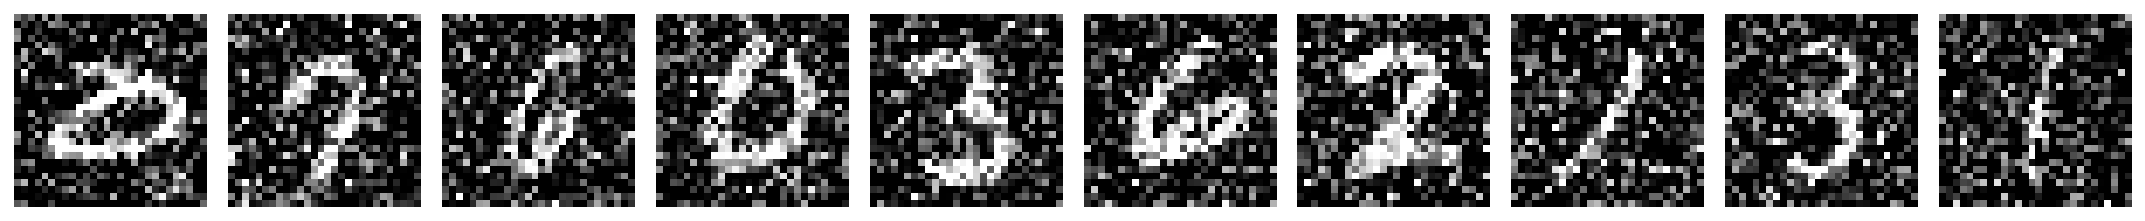

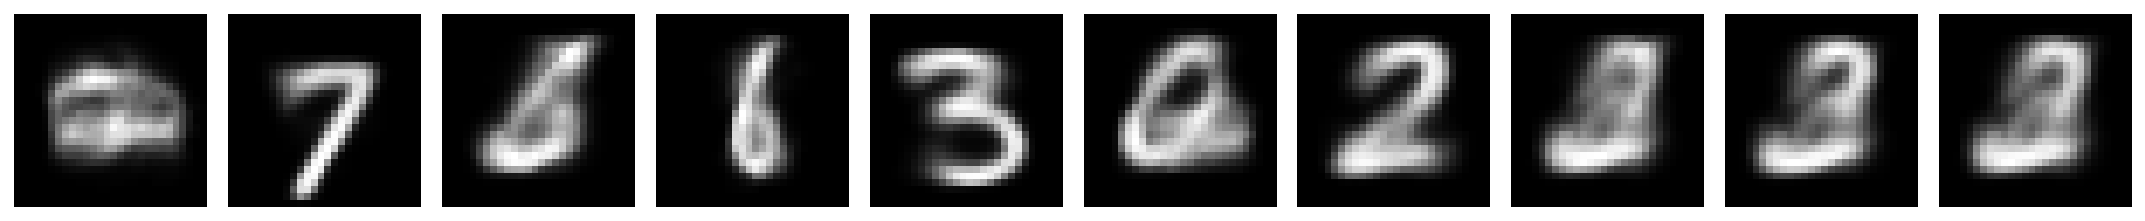

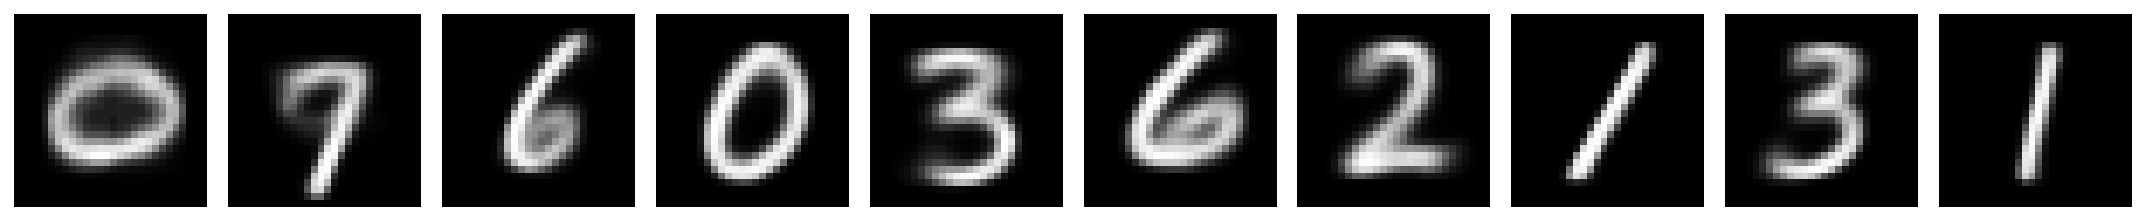

In [14]:
with torch.no_grad():
  output_test_noisy = model(input_test_noisy)
  latent_test_noisy = encoder(input_test_noisy)
  output_test = model(input_test)

plot_row([input_test_noisy[test_selected_idx],
          output_test_noisy[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

### Latent space before fine-tuning
We investigate the origin of reconstruction errors by looking at how adding noise to input affects latent space coordinates. The decoder interprets significant coordinate changes as different digits.

The function `plot_latent_ab` compares latent space coordinates for the same set of samples between two conditions.  Here, we display coordinates for the ten samples from the previous cell before and after adding noise:
* The left plot shows the coordinates of the original samples (noise-free)
* The plot on the right shows the new coordinates after adding noise

**Instructions:**
* Please execute the cell below

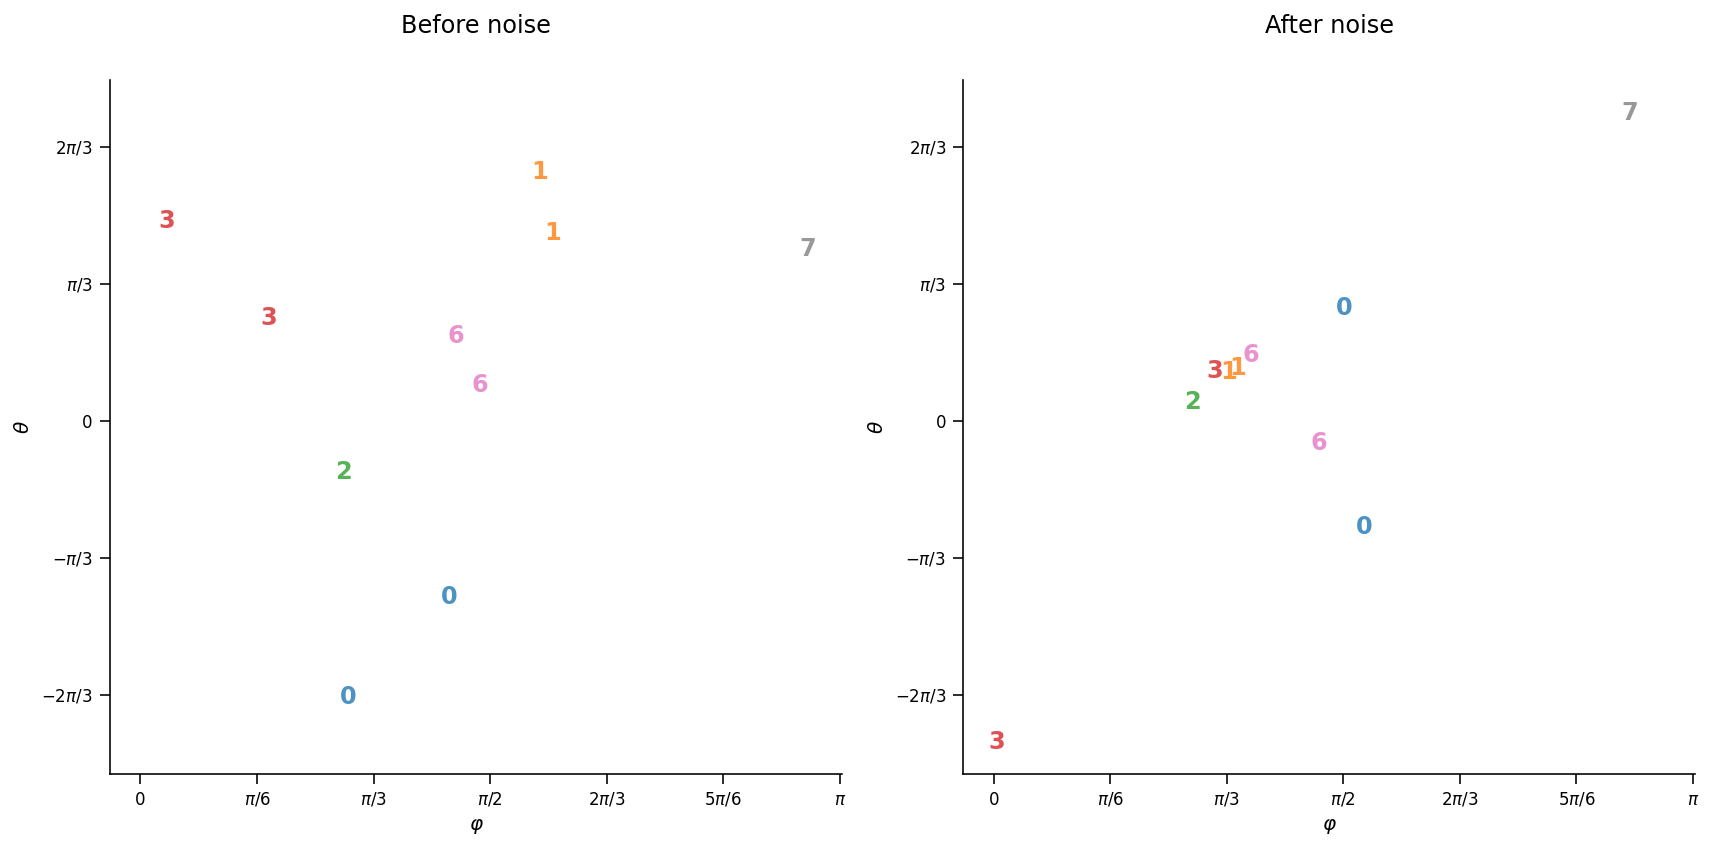

In [15]:
plot_latent_ab(latent_test, latent_test_noisy, y_test, test_selected_idx,
               title_a='Before noise', title_b='After noise', s2=s2)

### Fine-tuning the autoencoder with noisy images
Let's re-train the autoencoder with noisy images on the input and original (noise-free) images on the output, and regenerate the previous plots.

We now see that both noisy and noise-free images match similar locations in latent space. The network denoises the input with a latent-space representation that is more robust to noise.

**Instructions:**
* Please execute the cell(s) below

Epoch 	 Loss train 	 Loss test
1/3	 0.1764		 0.1771
2/3	 0.1749		 0.1757
3/3	 0.1733		 0.1746


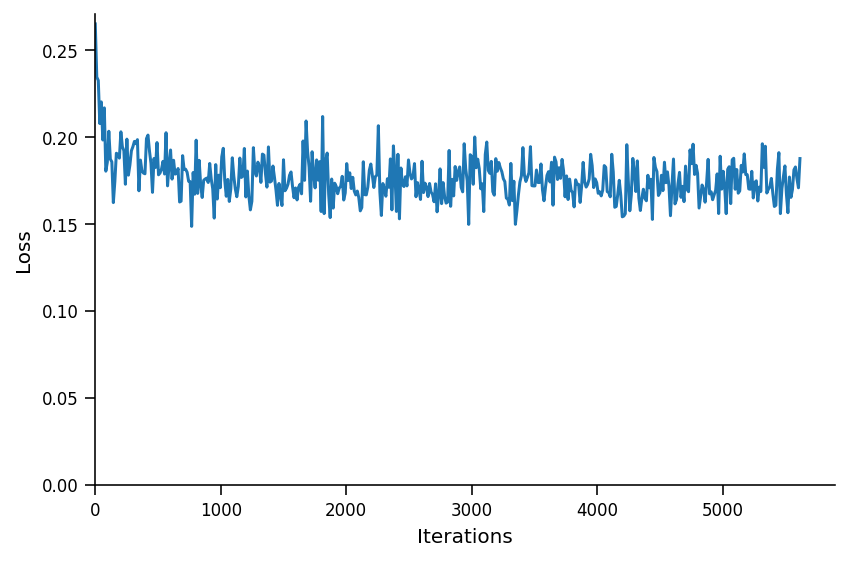

In [16]:
n_epochs = 3
batch_size = 32

model.train()

runSGD(model, input_train_noisy, input_test_noisy,
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

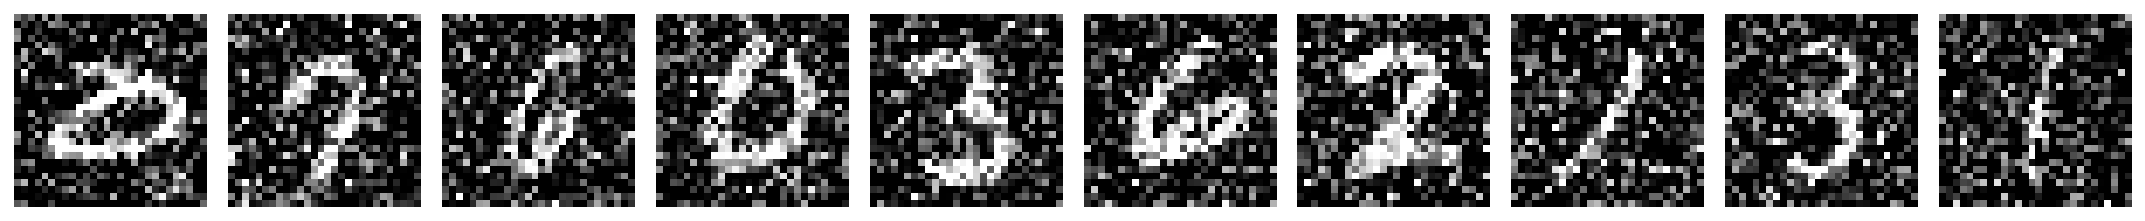

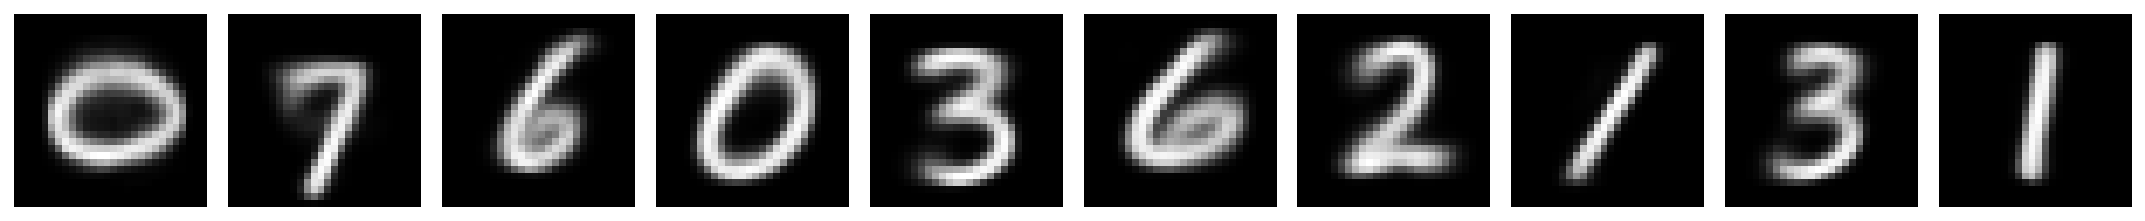

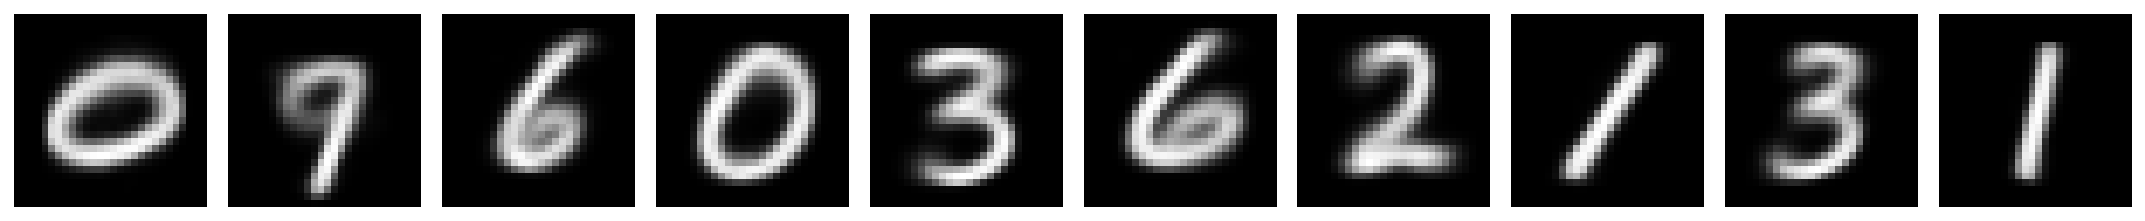

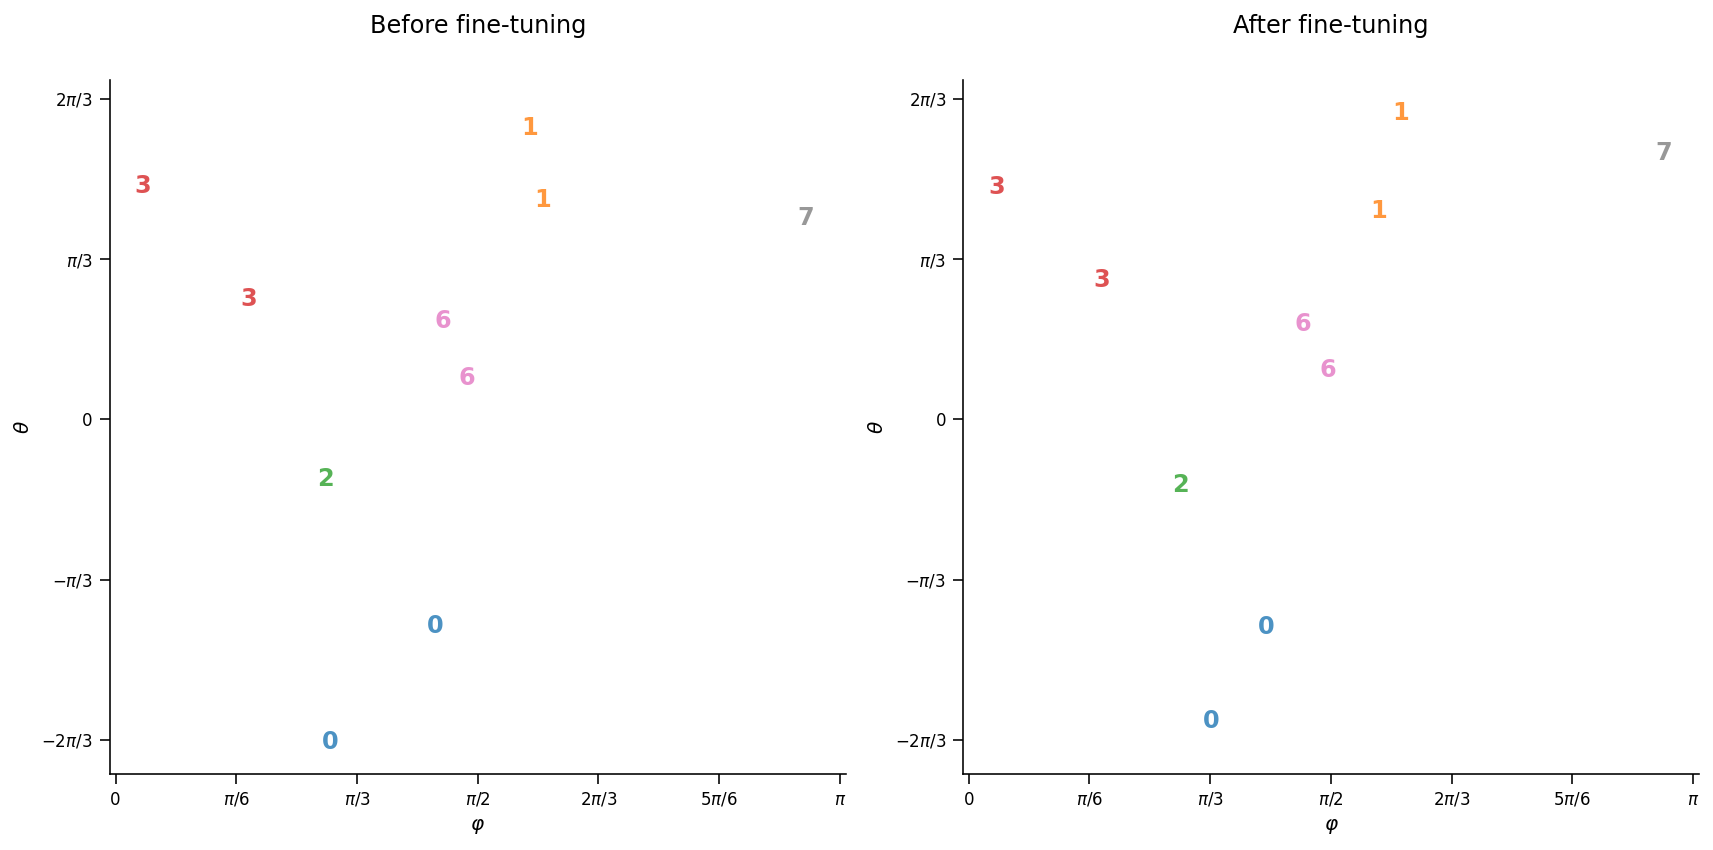

In [17]:
with torch.no_grad():
  output_test_noisy = model(input_test_noisy)
  latent_test_noisy = encoder(input_test_noisy)
  output_test = model(input_test)

plot_row([input_test_noisy[test_selected_idx],
          output_test_noisy[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_noisy, y_test, test_selected_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

### Global latent space shift
The new latent space representation is more robust to noise and may result in a better internal representation of the dataset. We verify this by inspecting the latent space with clean images before and after fine-tuning with noisy images.

Fine-tuning the network with noisy images causes a *domain shift* in the dataset, i.e., a change in the distribution of images since the dataset was initially composed of noise-free images. Depending on the task and the extent of changes during re-train,  (number of epochs, optimizer characteristics, etc.), the new latent space representation may become less well adapted to the original data as a side-effect. How could we address *domain shift* and improve both noisy and noise-free images?

**Instructions:**
* Please execute the cell(s) below

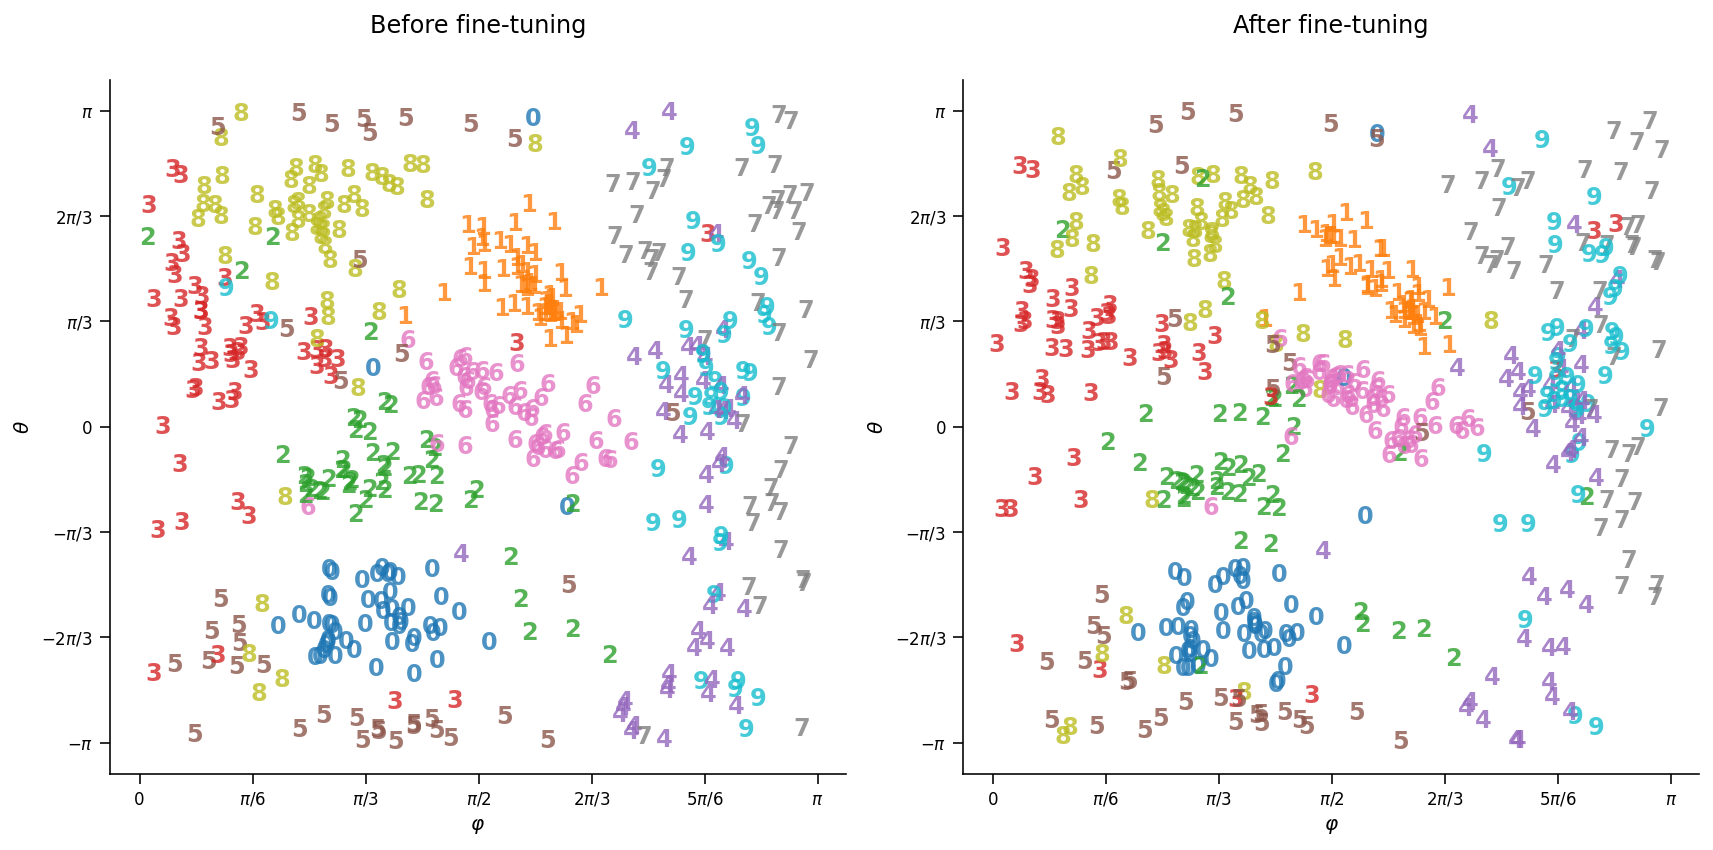

In [18]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, test_subset_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

## Application 2 - Image occlusion

We now investigate the effects of image occlusion. Drawing from the previous exercise, we expect the autoencoder to reconstruct complete images since the train set does not contain occluded images (right?).

We visualize this by plotting three rows:
* Top row with occluded images
* Middle row with reconstructions of occluded images
* Bottom row with reconstructions of the original images

![Occlusion task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/applications_occlusion.png)

Similarly, we investigate the source of this issue by looking at the representation of partial images in latent space and how it adjusts after fine-tuning.

**Instructions:**
* Please execute the cell(s) below

In [19]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Before fine-tuning

**Instructions:**
* Please execute the cell(s) below

In [20]:
input_train_mask = image_occlusion(input_train, image_shape=image_shape)
input_test_mask = image_occlusion(input_test, image_shape=image_shape)

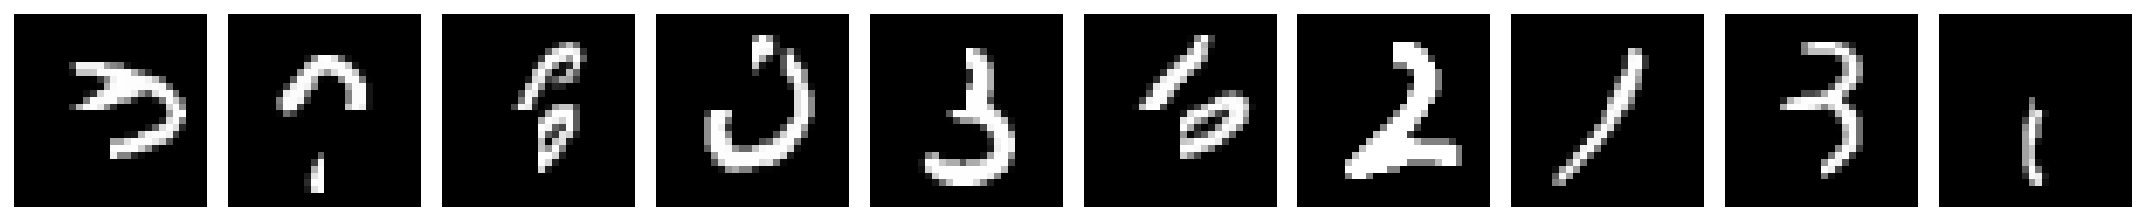

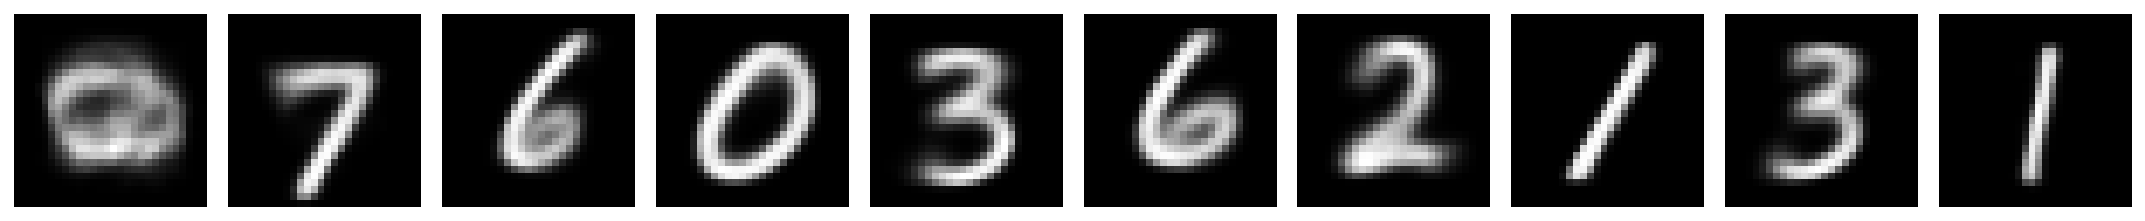

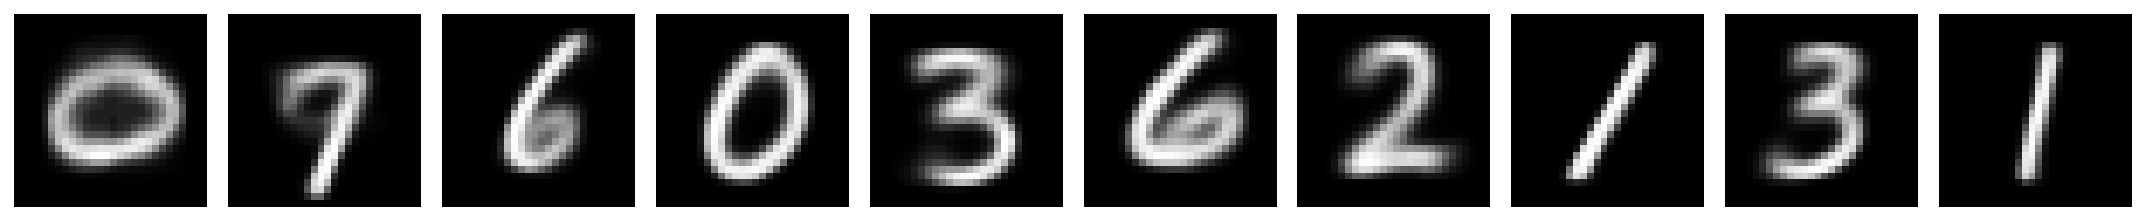

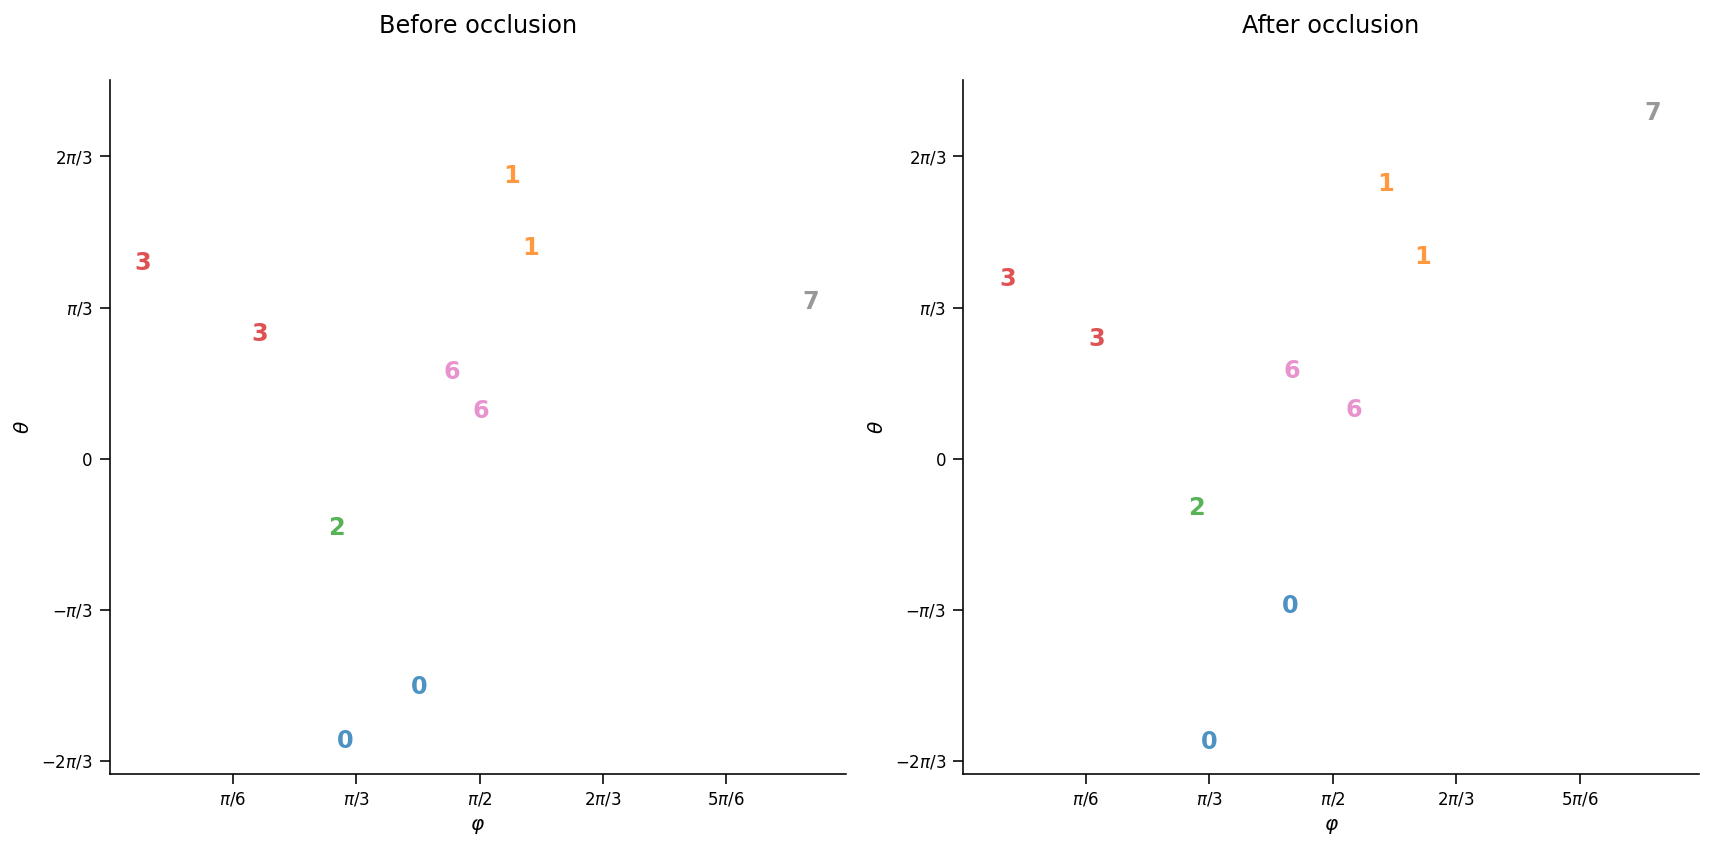

In [21]:
with torch.no_grad():
  output_test_mask = model(input_test_mask)
  latent_test_mask = encoder(input_test_mask)
  output_test = model(input_test)

plot_row([input_test_mask[test_selected_idx],
          output_test_mask[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_mask, y_test, test_selected_idx,
               title_a='Before occlusion', title_b='After occlusion', s2=s2)

### After fine-tuning

Epoch 	 Loss train 	 Loss test
1/3	 0.1731		 0.1745
2/3	 0.1707		 0.1724
3/3	 0.1704		 0.1719


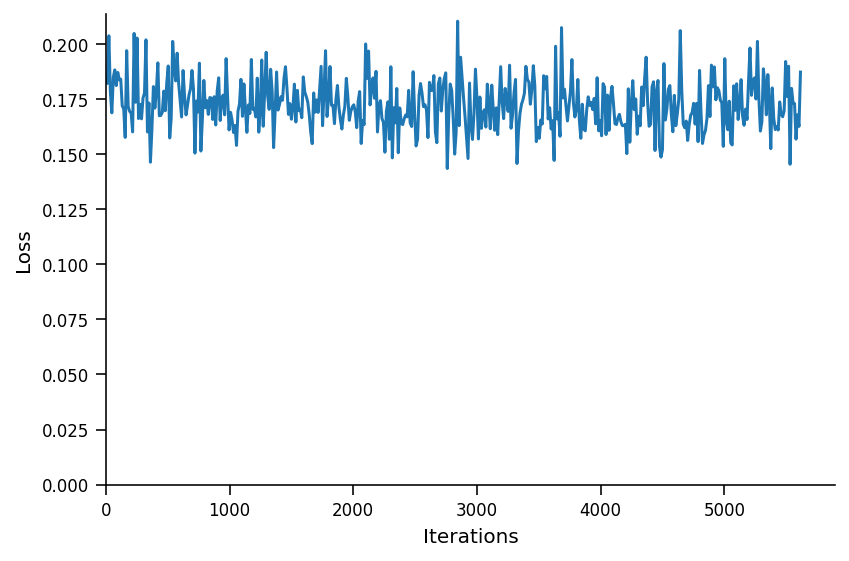

In [22]:
n_epochs = 3
batch_size = 32

model.train()

runSGD(model, input_train_mask, input_test_mask,
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

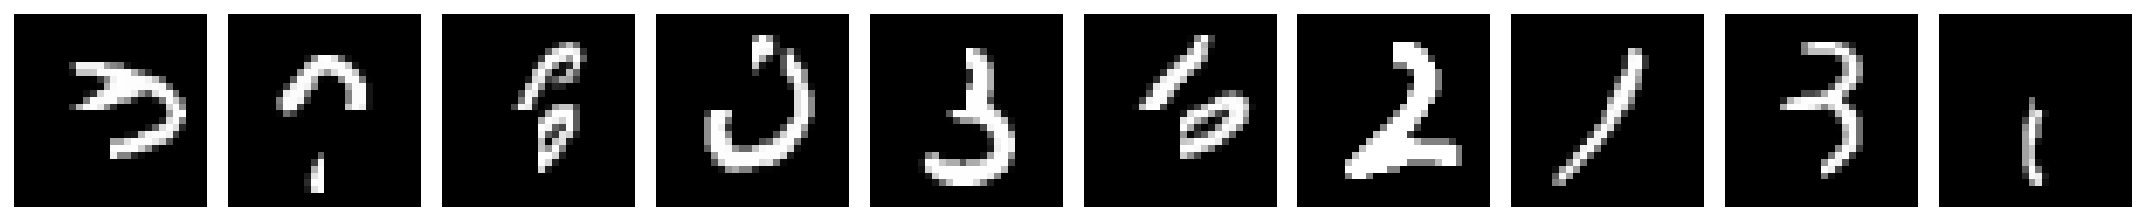

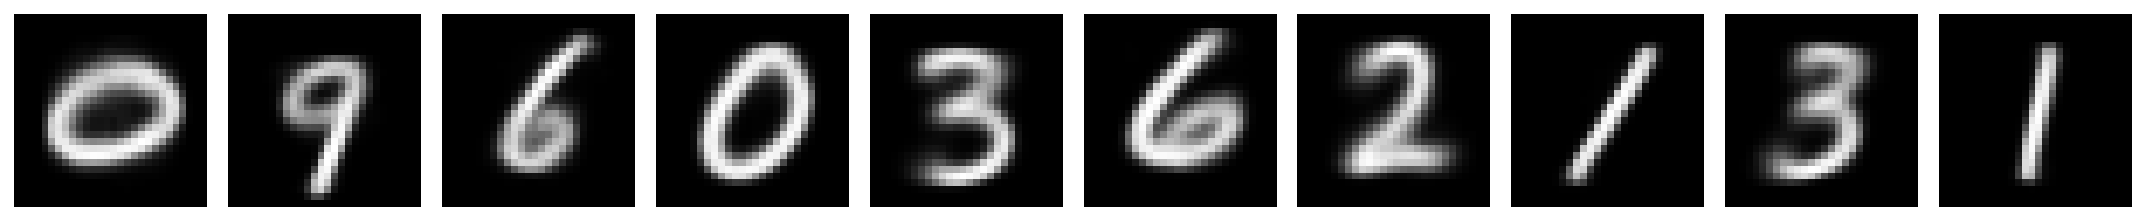

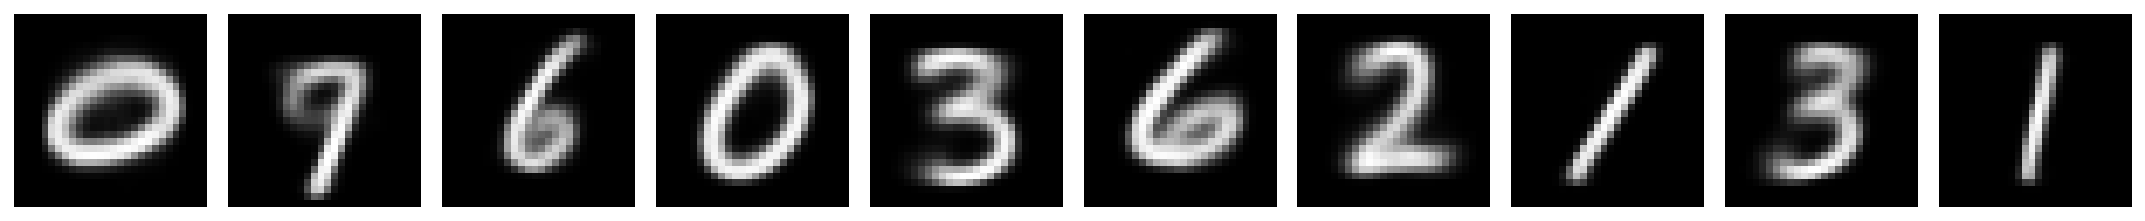

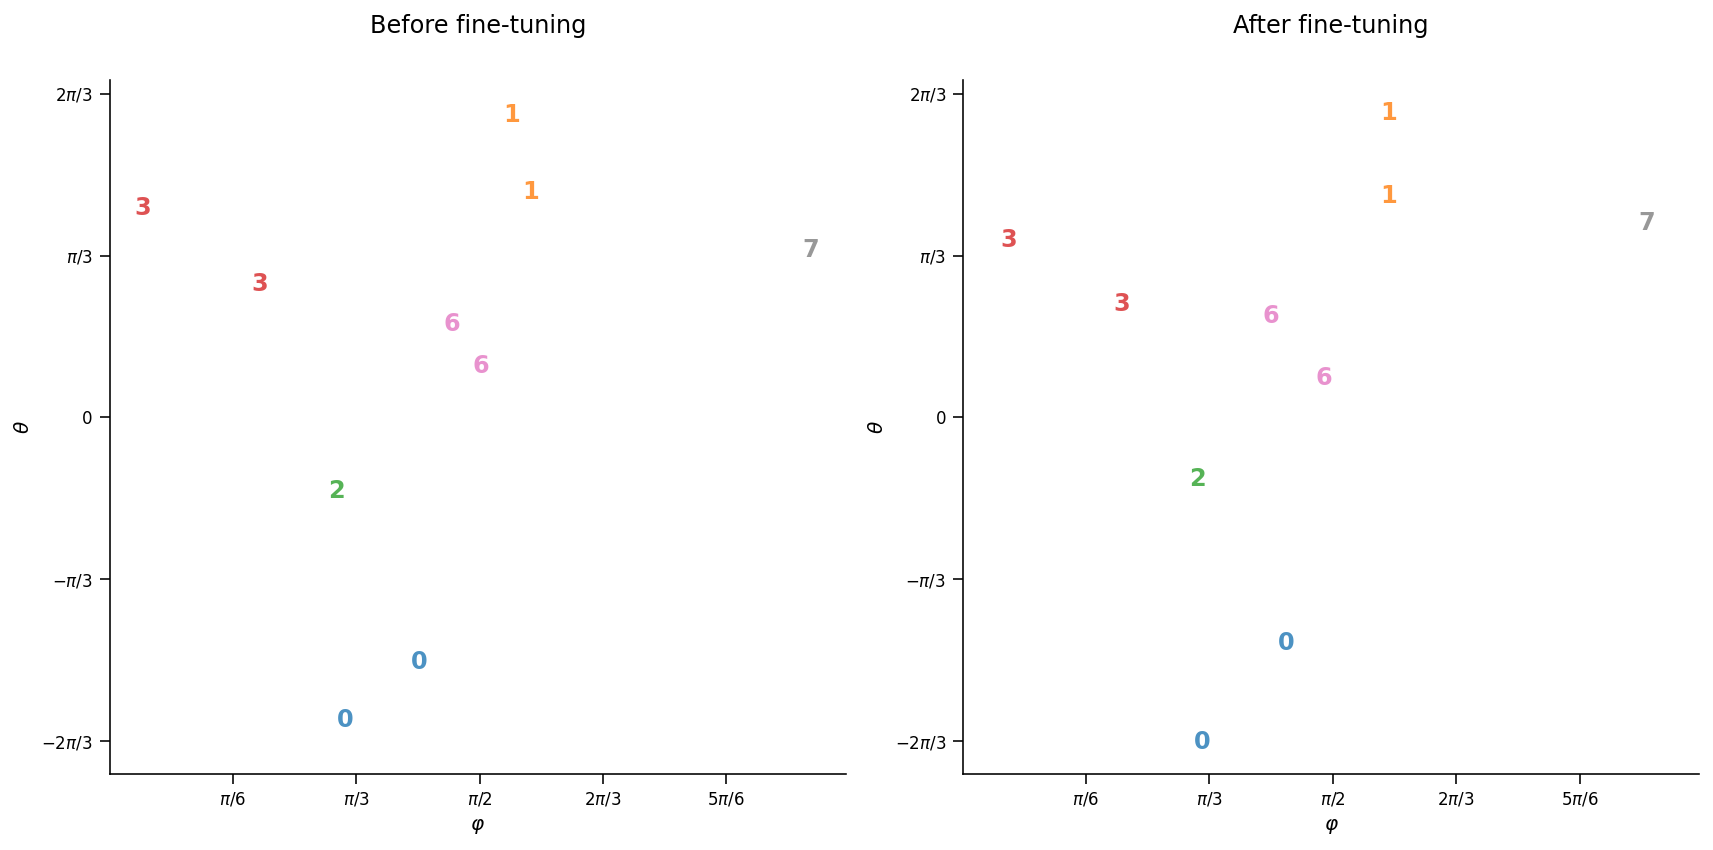

In [23]:
with torch.no_grad():
  output_test_mask = model(input_test_mask)
  latent_test_mask = encoder(input_test_mask)
  output_test = model(input_test)

plot_row([input_test_mask[test_selected_idx],
          output_test_mask[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_mask, y_test, test_selected_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

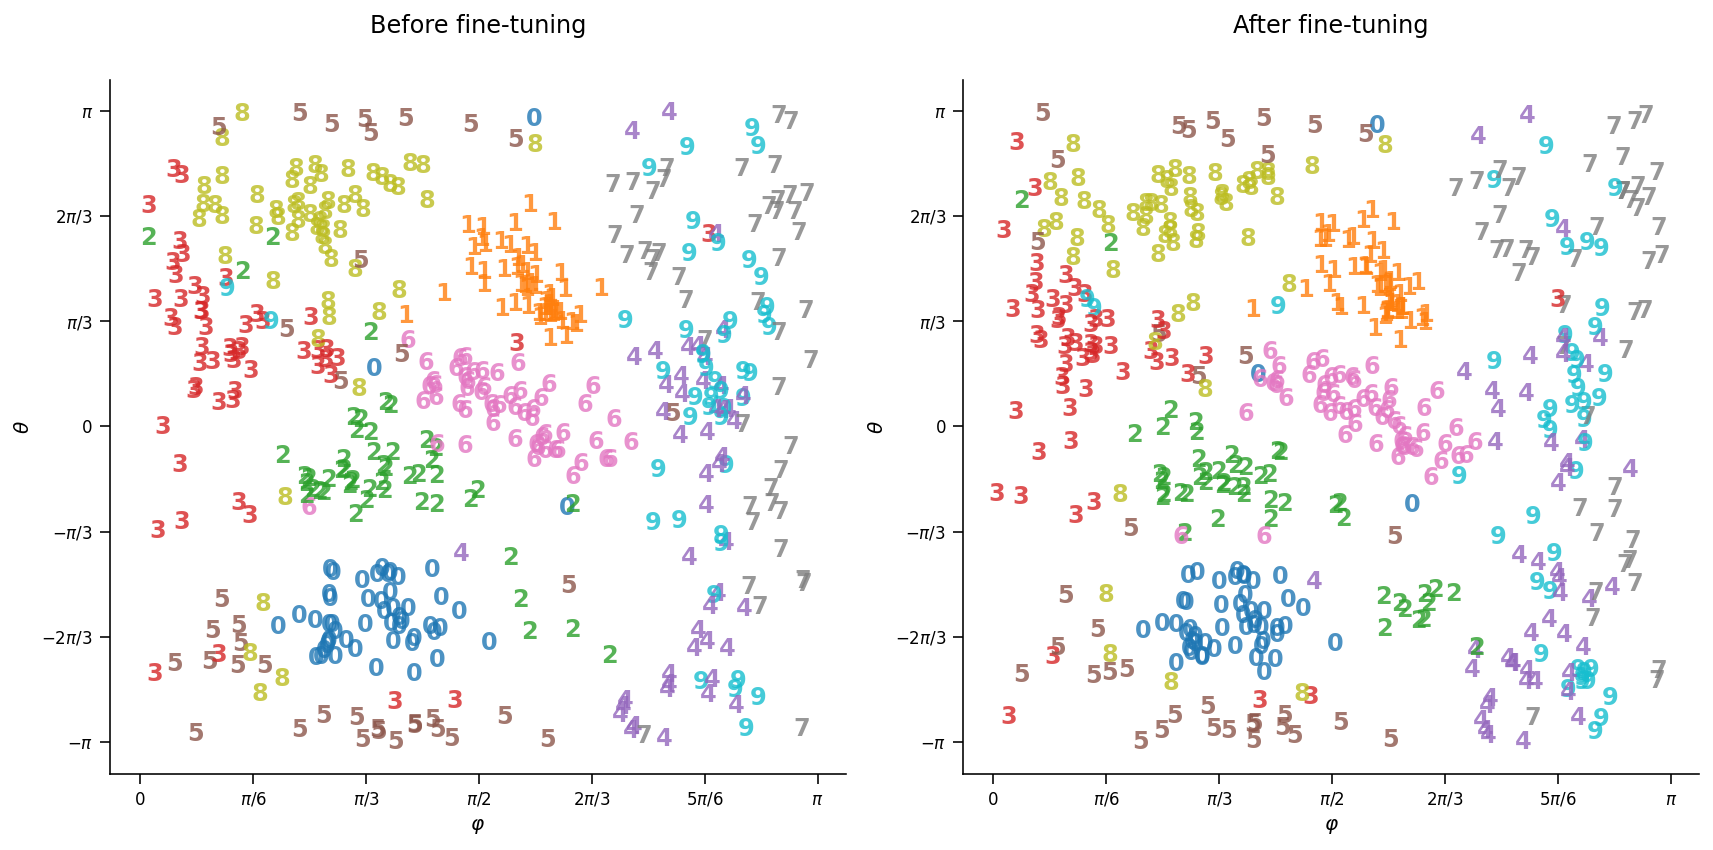

In [24]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, test_subset_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

## Application 3 - Image rotation

Finally, we look at the effect of image rotation in latent space coordinates. This task is arguably more challenging since it may require a complete re-write of image reconstruction.

We visualize this by plotting three rows:
* Top row with rotated images
* Middle row with reconstructions of rotated images
* Bottom row with reconstructions of the original images

![Rotation task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/applications_rotation.png)

We investigate the source of this issue by looking at the representation of rotated images in latent space and how it adjusts after fine-tuning.

**Instructions:**
* Please execute the cell(s) below

In [25]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Before fine-tuning

**Instructions:**
* Please execute the cell(s) below

In [26]:
input_train_rotation = image_rotation(input_train, 90, image_shape=image_shape)
input_test_rotation = image_rotation(input_test, 90, image_shape=image_shape)

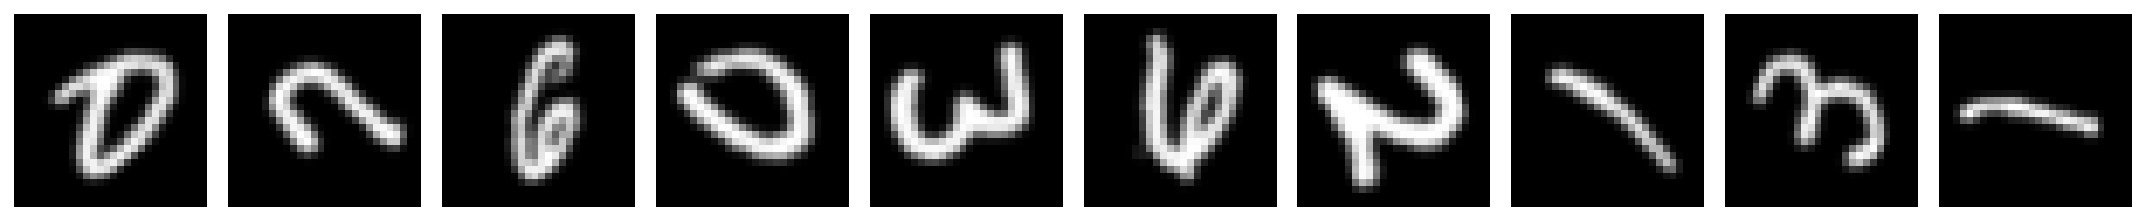

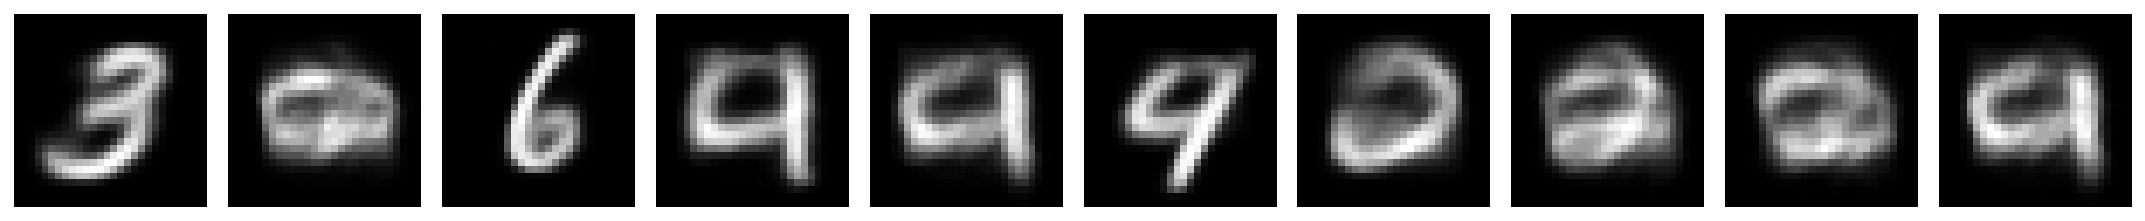

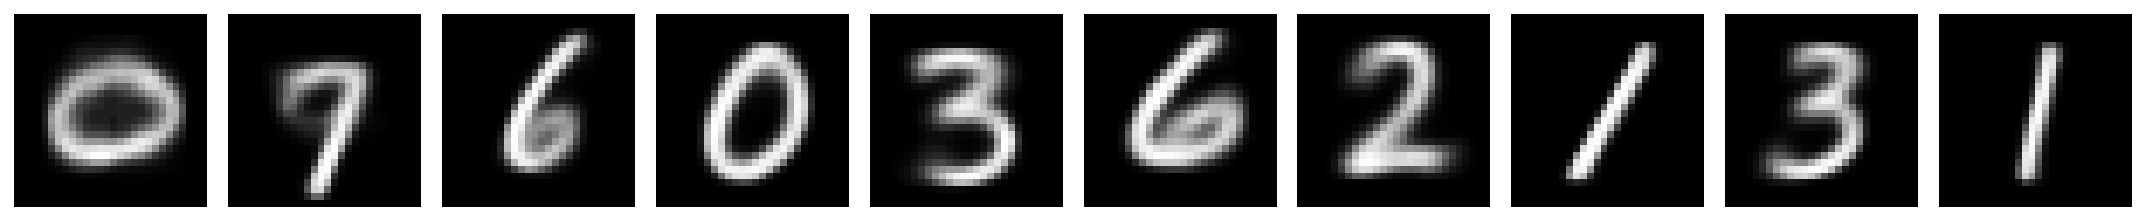

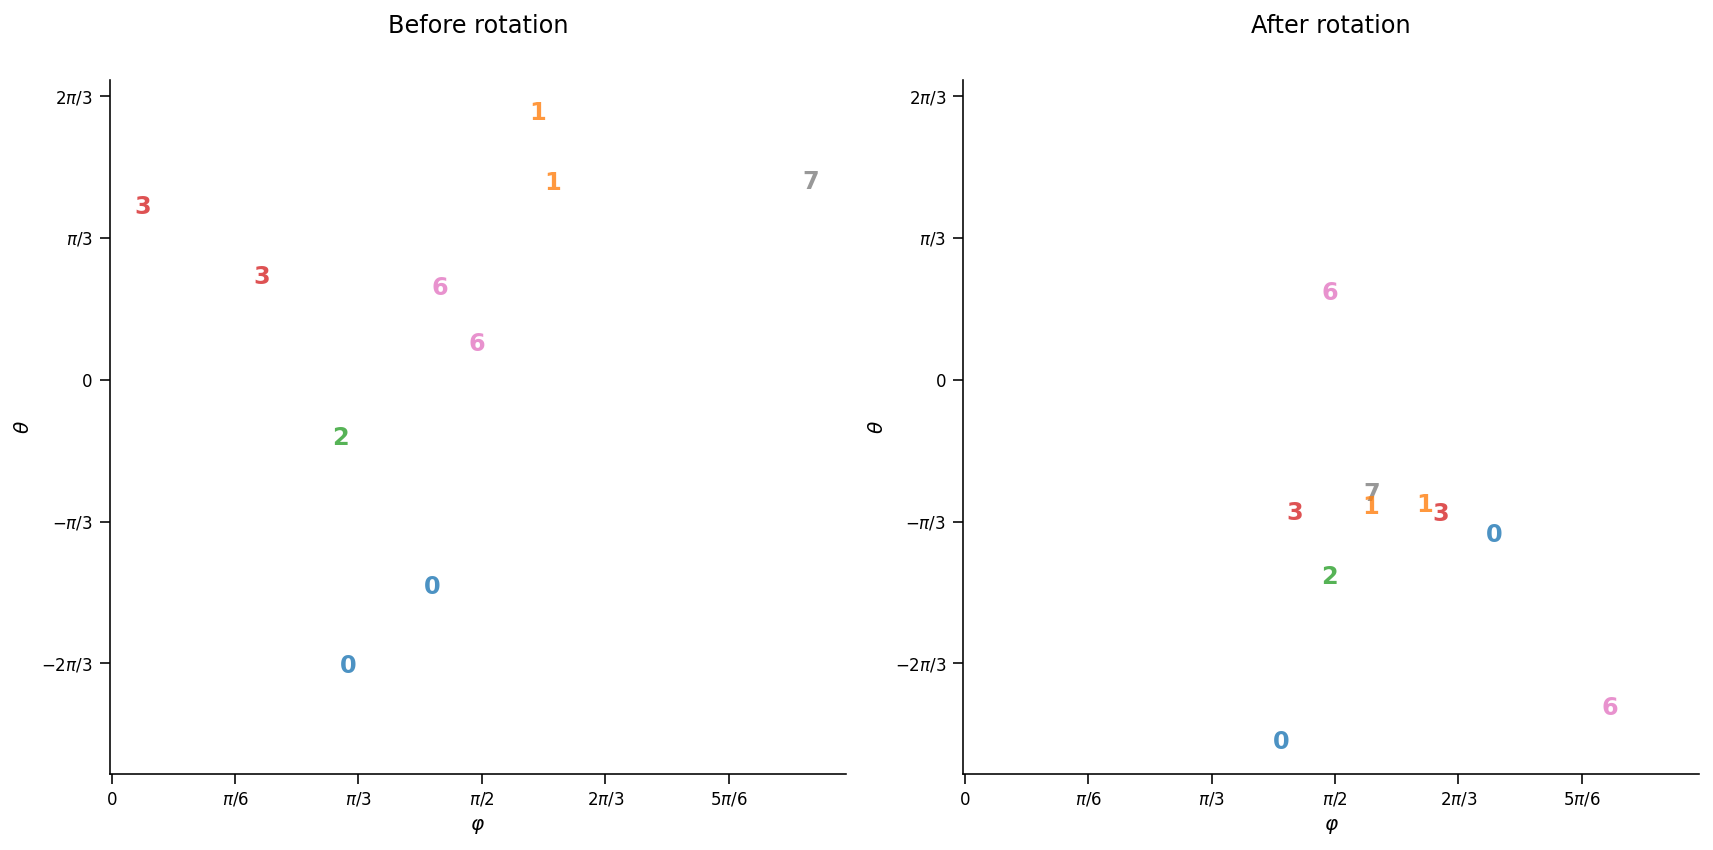

In [27]:
with torch.no_grad():
  output_test_rotation = model(input_test_rotation)
  latent_test_rotation = encoder(input_test_rotation)
  output_test = model(input_test)

plot_row([input_test_rotation[test_selected_idx],
          output_test_rotation[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_rotation, y_test, test_selected_idx,
               title_a='Before rotation', title_b='After rotation', s2=s2)

### After fine-tuning

**Instructions:**
* Please execute the cell(s) below

Epoch 	 Loss train 	 Loss test
1/5	 0.2207		 0.2201
2/5	 0.2121		 0.2126
3/5	 0.2085		 0.2094
4/5	 0.2050		 0.2058
5/5	 0.2029		 0.2039


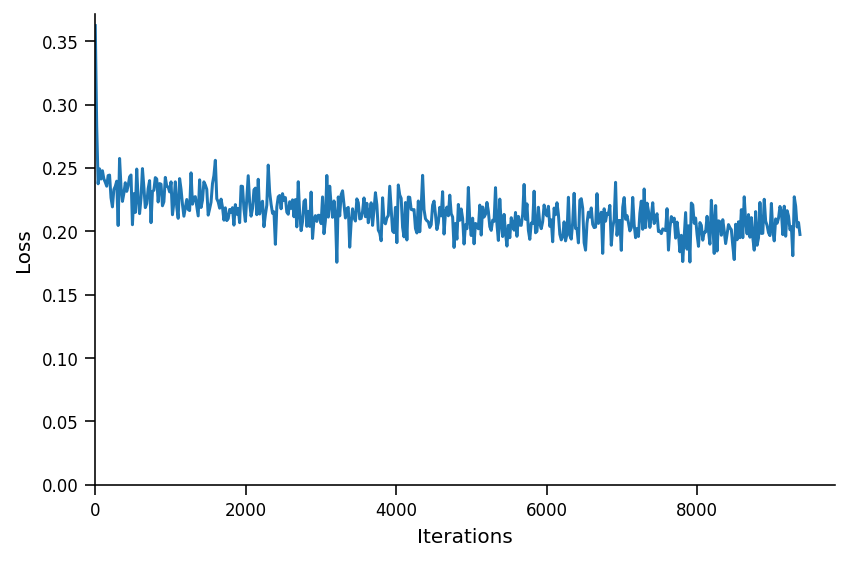

In [28]:
n_epochs = 5
batch_size = 32

model.train()

runSGD(model, input_train_rotation, input_test_rotation,
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

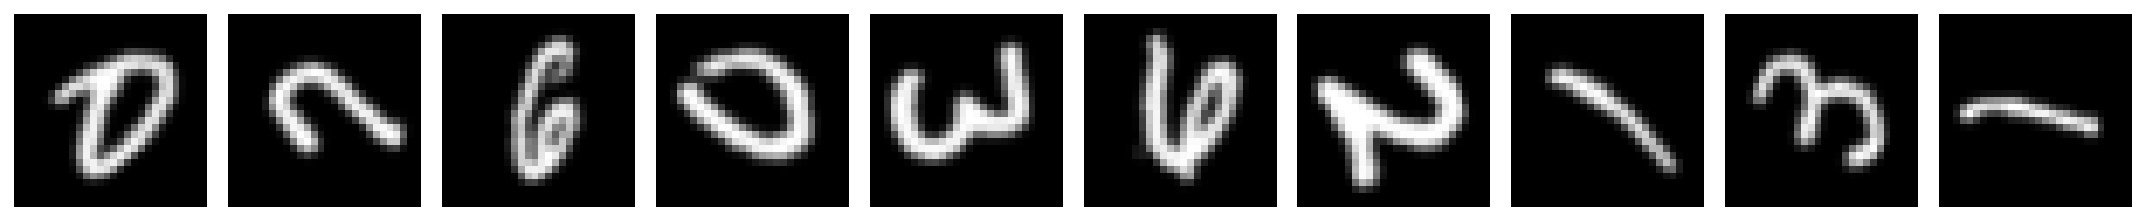

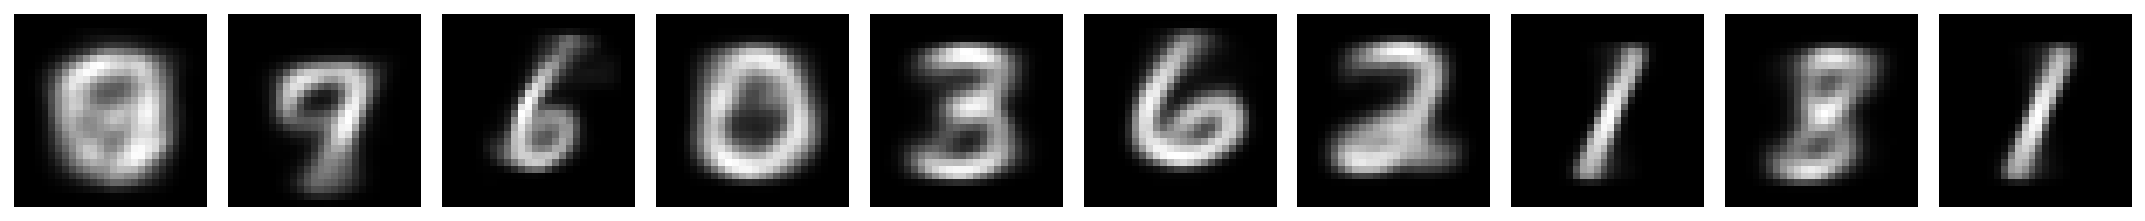

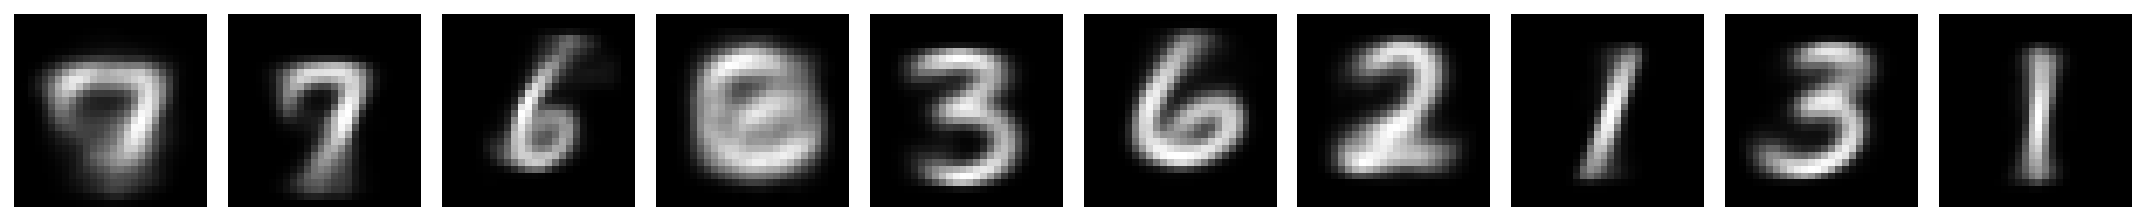

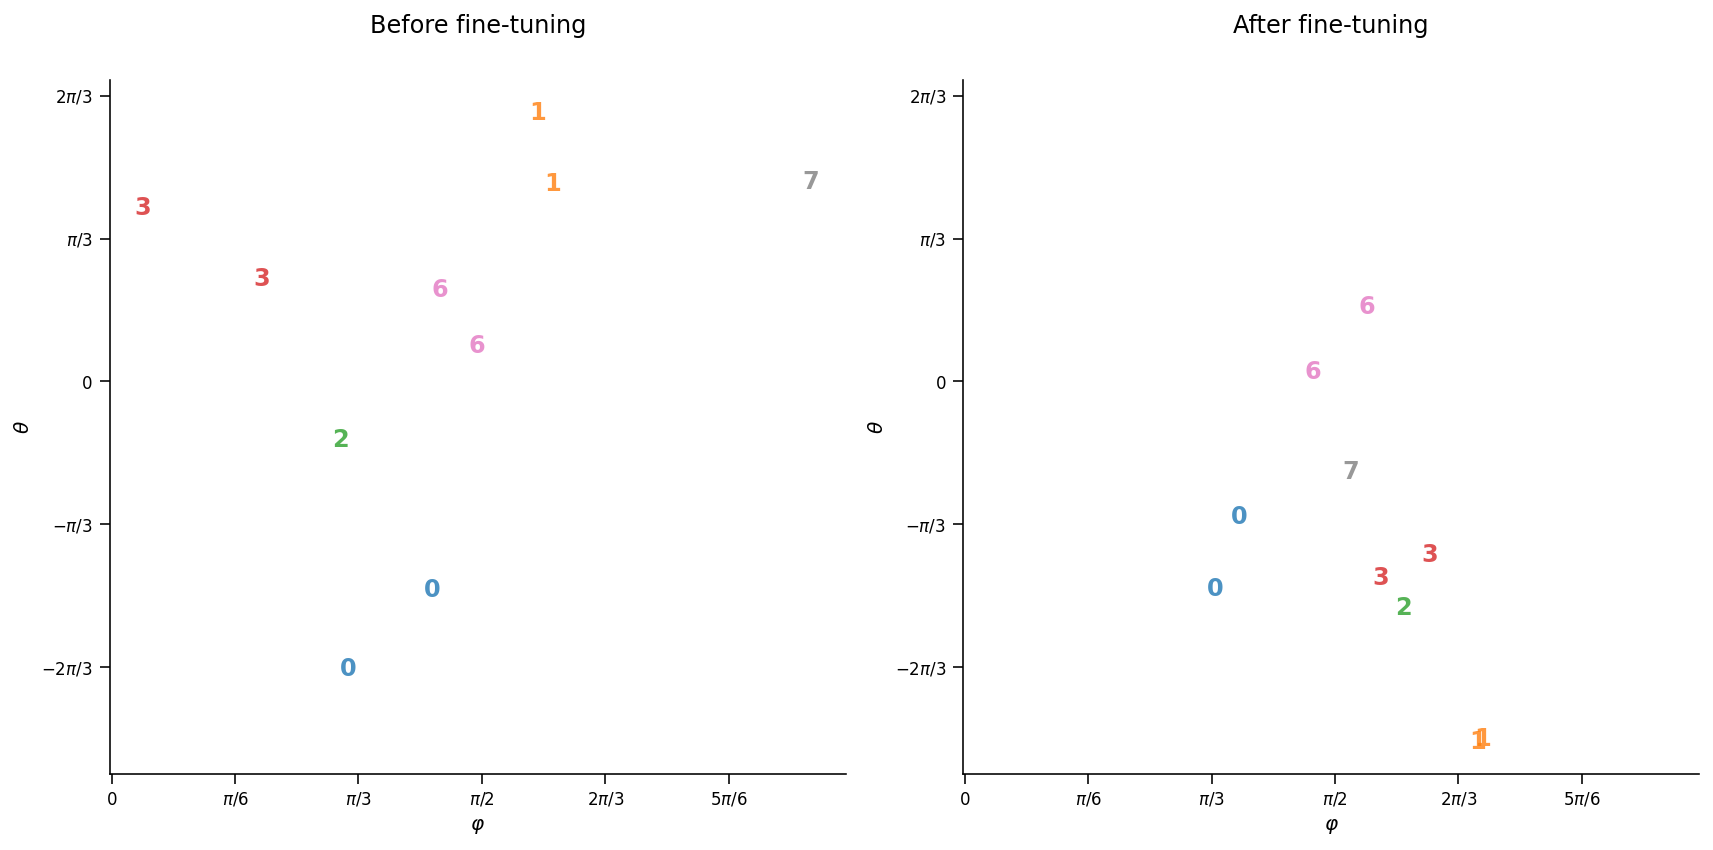

In [29]:
with torch.no_grad():
  output_test_rotation = model(input_test_rotation)
  latent_test_rotation = encoder(input_test_rotation)
  output_test = model(input_test)

plot_row([input_test_rotation[test_selected_idx],
          output_test_rotation[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_rotation, y_test, test_selected_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

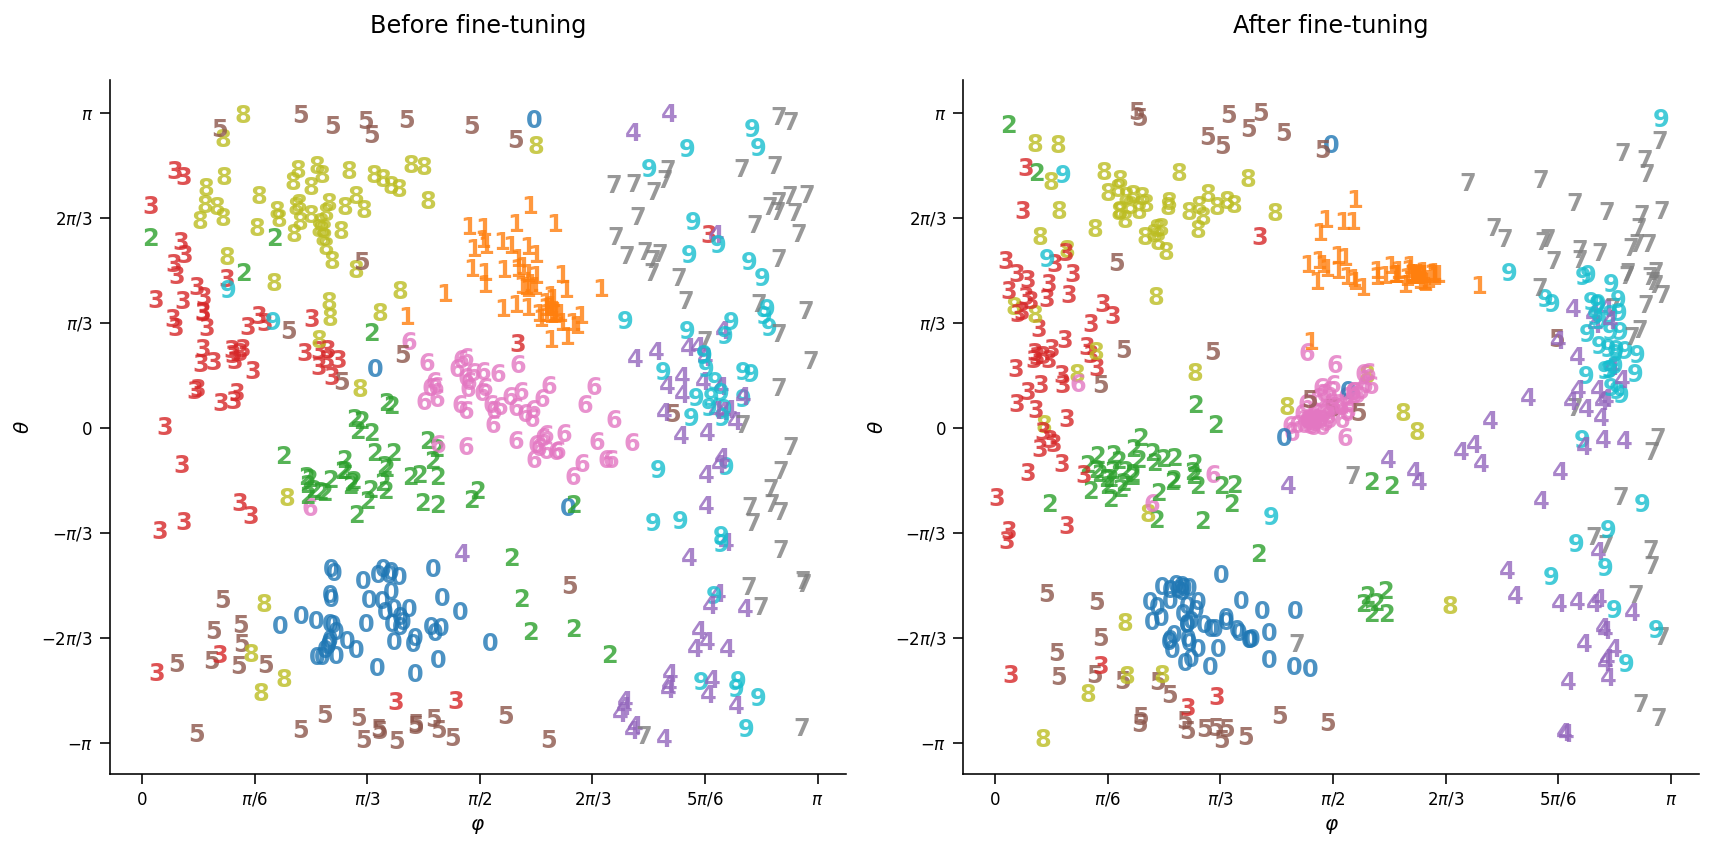

In [30]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, test_subset_idx,
               title_a='Before fine-tuning',
               title_b='After fine-tuning', s2=s2)

## Application 4 - What would digit "6" look like if we had never seen it before?
Before we start melting our brains with such an impossible task, let's just ask the autoencoder to do it!

We train the autoencoder from scratch without digit class `6` and visualize reconstructions from digit `6`.

**Instructions:**
* Please execute the cell(s) below

In [31]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

In [32]:
missing = 6

my_input_train = input_train[y_train != missing]
my_input_test = input_test[y_test != missing]
my_y_test = y_test[y_test != missing]

Epoch 	 Loss train 	 Loss test
1/3	 0.1900		 0.1889
2/3	 0.1810		 0.1805
3/3	 0.1769		 0.1761


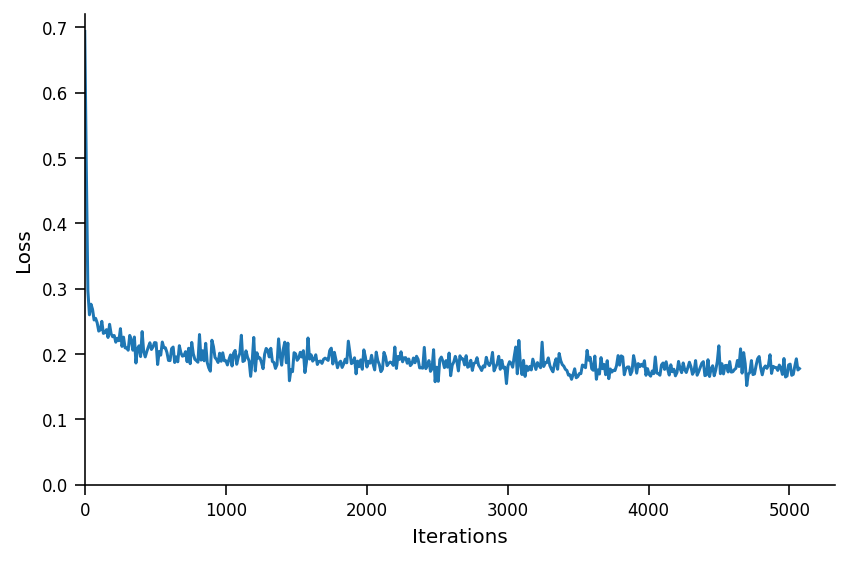

In [33]:
n_epochs = 3
batch_size = 32

runSGD(model, my_input_train, my_input_test,
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)
  my_latent_test = encoder(my_input_test)

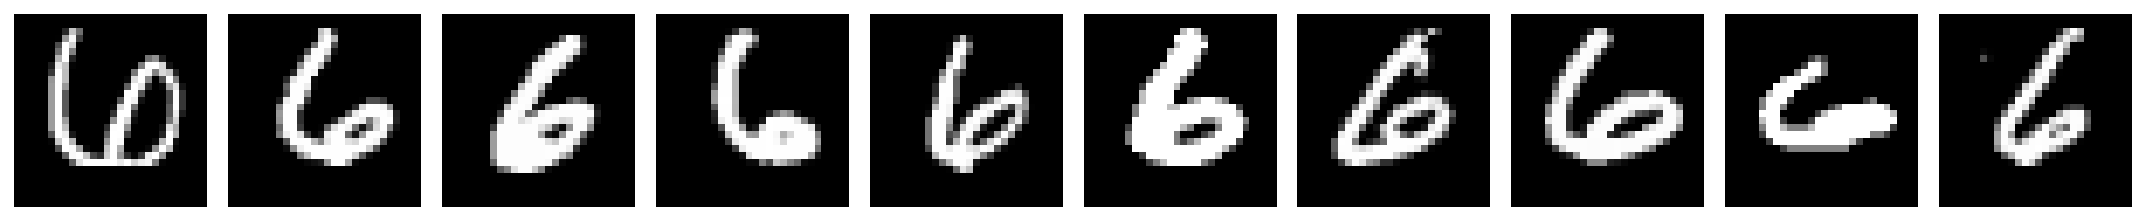

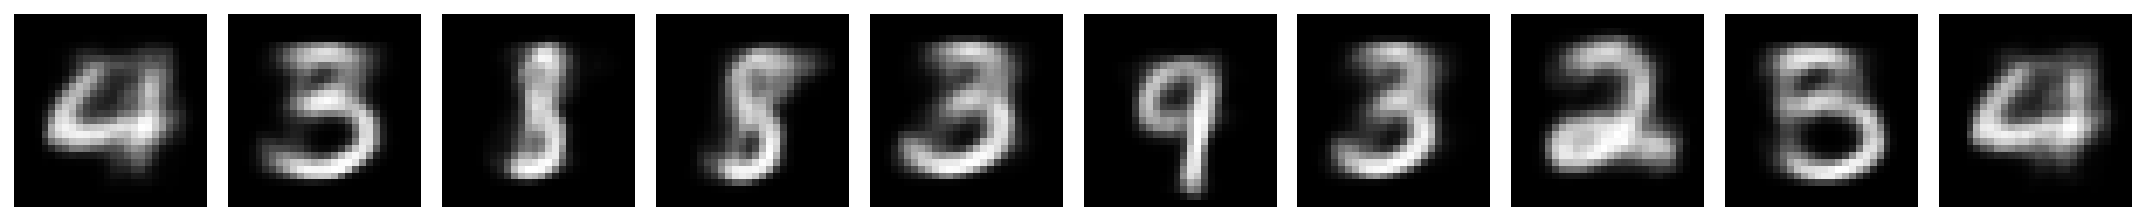

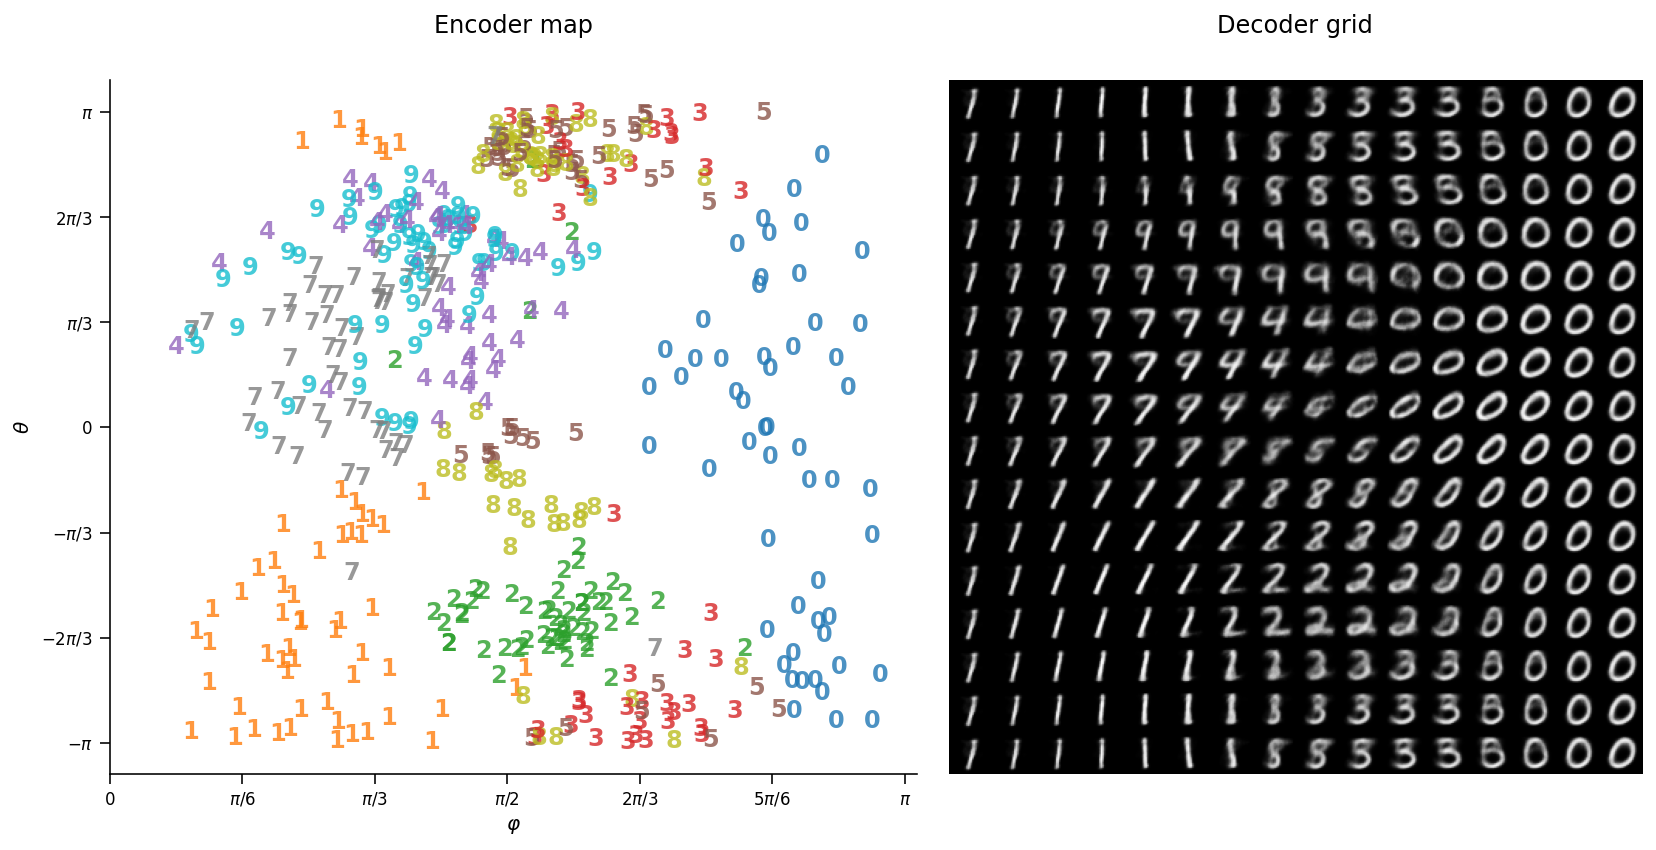

In [34]:
plot_row([input_test[y_test == 6], output_test[y_test == 6]],
         image_shape=image_shape)

plot_latent_generative(my_latent_test, my_y_test, decoder,
                       image_shape=image_shape, s2=s2)

### Exercise 1: Removing the most dominant digit classes
Digit classes `0` and `1` are dominant in the sense that these occupy large areas of the decoder grid, compared to other digit classes that occupy very little generative space.

How will latent space change when removing the two most dominant digit classes? Will latent space re-distribute evenly among remaining classes or choose another two dominant classes?

**Instructions:**
* Please execute the cell(s) below
* The intersection of two boolean arrays by condition is specified as `x[(cond_a)&(cond_b)]`

In [ ]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

In [ ]:
missing_a = 1
missing_b = 0
#################################################
## TODO for students:
#################################################
# input train data
# my_input_train = ...
# input test data
# my_input_test = ...
# model
# my_y_test = ...

# Uncomment to test your code
# print(my_input_train.shape)
# print(my_input_test.shape)
# print(my_y_test.shape)

**SAMPLE OUTPUT**

```
torch.Size([47335, 784])
torch.Size([7885, 784])
torch.Size([7885])
```

In [ ]:
# to_remove solution
missing_a = 1
missing_b = 0
# input train data
my_input_train = input_train[(y_train != missing_a) & (y_train != missing_b)]
# input test data
my_input_test = input_test[(y_test != missing_a) & (y_test != missing_b)]
# model
my_y_test = y_test[(y_test != missing_a) & (y_test != missing_b)]

# Uncomment to test your code
print(my_input_train.shape)
print(my_input_test.shape)
print(my_y_test.shape)

In [ ]:
n_epochs = 3
batch_size = 32

runSGD(model, my_input_train, my_input_test,
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)
  my_latent_test = encoder(my_input_test)

In [ ]:
plot_row([input_test[y_test == missing_a], output_test[y_test == missing_a]],
         image_shape=image_shape)

plot_row([input_test[y_test == missing_b], output_test[y_test == missing_b]],
         image_shape=image_shape)

plot_latent_generative(my_latent_test, my_y_test, decoder,
                       image_shape=image_shape, s2=s2)

---
# Section 4: ANNs? Same but different!
"Same same but different" is an expression used in some parts of Asia to express differences between supposedly similar subjects. In this exercise, we investigate a fundamental difference in how fully-connected ANNs process visual information compared to human vision.

The previous exercises showed ANN autoencoder performing cognitive tasks with relative ease. However, there is a crucial aspect of ANN processing already encoded in the vectorization of images. This network architecture completely ignores the relative position of pixels. To illustrate this, we show that learning proceeds just as well with shuffled pixel locations.

First, we obtain a reversible shuffle map stored in `shuffle_image_idx` used to shuffle image pixels randomly.

<br>

![mnist_pixel_shuffle](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mnist_pixel_shuffle.png)

<br>

The unshuffled image set `input_shuffle` is recovered as follows:

```python
input_shuffle[:, shuffle_rev_image_idx]]
```

First, we set up the reversible shuffle map and visualize a few images with shuffled and unshuffled pixels, followed by their noisy versions.

**Instructions:**
* Please execute the cell(s) below

In [ ]:
# create forward and reverse indexes for pixel shuffling
shuffle_image_idx = np.arange(input_size)
shuffle_rev_image_idx = np.empty_like(shuffle_image_idx)

# shuffle pixel location
np.random.shuffle(shuffle_image_idx)

# store reverse locations
for pos_idx, pos in enumerate(shuffle_image_idx):
  shuffle_rev_image_idx[pos] = pos_idx

# shuffle train and test sets
input_train_shuffle = input_train[:, shuffle_image_idx]
input_test_shuffle = input_test[:, shuffle_image_idx]

input_train_shuffle_noisy = input_train_noisy[:, shuffle_image_idx]
input_test_shuffle_noisy = input_test_noisy[:, shuffle_image_idx]

# show samples with shuffled pixels
plot_row([input_test_shuffle,
          input_test_shuffle[:, shuffle_rev_image_idx]],
         image_shape=image_shape)

In [ ]:
# show noisy samples with shuffled pixels
plot_row([input_train_shuffle_noisy[test_selected_idx],
          input_train_shuffle_noisy[:, shuffle_rev_image_idx][test_selected_idx]],
         image_shape=image_shape)

We initialize and train the network in the denoising task with shuffled pixels.

**Instructions:**
* Please execute the cell below

In [ ]:
model = AutoencoderClass(s2=s2)

encoder = model.encoder
decoder = model.decoder

n_epochs = 3
batch_size = 32

# train the model to denoise shuffled images
runSGD(model, input_train_shuffle_noisy, input_test_shuffle_noisy,
       out_train=input_train_shuffle, out_test=input_test_shuffle,
       n_epochs=n_epochs, batch_size=batch_size)

Finally, visualize reconstructions and latent space representation with the trained model.

We visualize reconstructions by plotting three rows:
* Top row with shuffled noisy images
* Middle row with reconstructions of shuffled denoised images
* Bottom row with unshuffled reconstructions of denoised images

![mnist_pixel_shuffle denoised](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/applications_ann_denoise.png)

We obtain the same organization in the encoder map as before. Sharing similar internal representations confirms the network to ignore the relative position of pixels. The decoder grid is different than before since it generates shuffled images.

**Instructions:**
* Please execute the cell below

In [ ]:
with torch.no_grad():
  latent_test_shuffle_noisy = encoder(input_test_shuffle_noisy)
  output_test_shuffle_noisy = model(input_test_shuffle_noisy)

plot_row([input_test_shuffle_noisy[test_selected_idx],
          output_test_shuffle_noisy[test_selected_idx],
          output_test_shuffle_noisy[:, shuffle_rev_image_idx][test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test_shuffle_noisy, y_test, decoder,
                       image_shape=image_shape, s2=s2)

---
# Summary
Hooray! You have finished the last Tutorial of NMA 2020!

We hope you've enjoyed these tutorials and learned about the usefulness of autoencoders to model rich and non-linear representations of data. We hope you may find them useful in your research, perhaps to model certain aspects of cognition or even extend them to biologically plausible architectures - autoencoders of spiking neurons, anyone?

These are the key take away messages from these tutorials:

**Autoencoders trained in *learning by doing* tasks such as compression/decompression, removing noise, etc. can uncover rich lower-dimensional structure embedded in structured images and other cognitively relevant data.**

**The data domain seen during training imprints a "cognitive bias" - you only see what you expect to see, which can only be similar to what you saw before.**

Such bias is related to the concept [*What you see is all there is*](https://en.wikipedia.org/wiki/Thinking,_Fast_and_Slow) coined by Daniel Kahneman in psychology.

For additional applications of autoencoders to neuroscience, check the spike sorting application in the outro video, and also see [here](https://www.nature.com/articles/s41592-018-0109-9) how to replicate the input-output relationship of real networks of neurons with autoencoders.

In [ ]:
# @title Video 2: Wrap-up
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ph411Z7uh", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ziiZK9P6AXQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)